$ \huge \text{Sentiment analysis on imdb dataset using LSTM.}$

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import pickle

In [2]:
device=torch.device('cuda:1' if torch.cuda.is_available else 'cpu')

In [3]:
base_csv = 'IMDB_Dataset.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


$\huge \text{Splitting to train and test data}$

$\text{We will split data to train and test initially. Doing this on earlier stage allows to avoid data lekage.}$


In [4]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


$\huge \text{Tockenization}$

In [5]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = [1 if label =='positive' else 0 for label in y_train]
    encoded_test = [1 if label =='positive' else 0 for label in y_val]
    return np.array(final_list_train,dtype=object), np.array(encoded_train),np.array(final_list_test,dtype=object), np.array(encoded_test),onehot_dict


In [6]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

In [7]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 149790


$\huge \text{Padding}$

$\large \text{Now we will pad each of the sequence to max length}$

In [8]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [9]:

x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)


$\huge \text{Batching and loading as tensor}$

In [10]:
# Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)
train_loader_acc=DataLoader(train_data, shuffle=False, batch_size=batch_size)

In [11]:
# obtain one batch of training data
for i,(sample_x,sample_y) in enumerate(train_loader):


  print('Sample input size: ', sample_x.size()) # batch_size, seq_length
  print('Sample input: \n', sample_x)
  print('Sample input: \n', sample_y)
  break

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[    0,     0,     0,  ...,  9445,   689,     9],
        [    0,     0,     0,  ...,  1872,  1211,    64],
        [    0,     0,     0,  ...,    10,   690,    28],
        ...,
        [    0,     0,     0,  ...,   791,   327,     9],
        [    0,     0,     0,  ..., 86519,   374,    37],
        [    0,     0,     0,  ...,  2785,  1427,   555]])
Sample input: 
 tensor([0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0])


In [12]:
# Define the RNN model
class LSTM(nn.Module):
    def __init__(self, hidden_size, output_size,n_layers,embedding_dim):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers=n_layers
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_size,
                           num_layers=self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu=nn.ReLU()
        self.sigmoid=nn.Sigmoid()
        self.tanh=nn.Tanh()
        self.embed=nn.Embedding(len(vocab)+1,embedding_dim=embedding_dim)
    def forward(self, x):
       
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embed(x)
        # pass in the rnn layer
        output,hidden=self.lstm(embeds)
        
        
        output=output.contiguous().view(-1,self.hidden_size)
        
        output = self.sigmoid(self.fc(output))
        output=output.view(batch_size,-1)
        
        output=output[:,-1].view(batch_size,-1)
        
        return output

    def init_hidden(self,batch_size):
        hidden=torch.zeros(self.n_layers,batch_size,self.hidden_size).to(device)
        return hidden

In [13]:
import torch.nn as nn

In [14]:
def train_acc(model):
    acc=0
    for instances,labels in train_loader_acc:
        
        output=model(instances.to(device))
        for i in range(len(output)):
            if output[i]>=0.5 and labels[i]==1:
                acc+=1
            elif output[i]<0.5 and labels[i]==0:
                acc+=1
    del instances
    del labels
    return acc/len(train_data)
def valid_acc(model):
    acc=0
    for instances,labels in valid_loader:
        
        output=model(instances.to(device))
        for i in range(len(output)):
            if output[i]>=0.5 and labels[i]==1:
                acc+=1
            elif output[i]<0.5 and labels[i]==0:
                acc+=1
    del instances
    del labels
    return acc/len(valid_data)



def train_loss(model,batch_size,criterion):
    loss=0
    for instances,labels in train_loader_acc:
        labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
        output=model(instances.to(device))
        loss+=criterion(output,labels)
    del instances
    del labels
    return loss/batch_size
def valid_loss(model,batch_size,criterion):
    loss=0
    for instances,labels in valid_loader:
        labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
        output=model(instances.to(device))
        loss+=criterion(output,labels)
    del instances
    del labels
    return loss/batch_size
    
        
        

In [16]:
hidden_size=100
output_size=1
n_layers=2
embedding_dim=64
model=LSTM(hidden_size,output_size,n_layers,embedding_dim).to(device)
criterion =nn.BCELoss()
lr=0.0001
train_acc_list=[]
valid_acc_list=[]
loss_list=[]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs=100
num_epochs=tqdm(range(epochs))

# n_epochs=tqdm(range(epochs))
for epoch in num_epochs:

    running_loss = 0

    for i,(instances, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        instances=instances.to(device)
        labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
        # print(instances.shape)
        output = model(instances)
        loss = criterion(output, labels)


        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    loss_list.append(running_loss/batch_size)
    a=train_acc(model)
    train_acc_list.append(a)
    
    b=valid_acc(model)
    
    # print('accuracy over validation data set:',b)
    valid_acc_list.append(b)
    print('epoch is:',epoch+1,'accuracy over training/validation data set:',a,'/',b,' || running loss is:',running_loss/batch_size)
 


  1%|          | 1/100 [00:26<43:57, 26.64s/it]

epoch is: 1 accuracy over training/validation data set: 0.7117066666666667 / 0.71152  || running loss is: 9.694550860524178


  2%|▏         | 2/100 [00:53<44:10, 27.05s/it]

epoch is: 2 accuracy over training/validation data set: 0.7993066666666667 / 0.78672  || running loss is: 7.470973235368729


  3%|▎         | 3/100 [01:18<42:01, 26.00s/it]

epoch is: 3 accuracy over training/validation data set: 0.8408533333333333 / 0.81968  || running loss is: 6.14305756777525


  4%|▍         | 4/100 [01:43<41:03, 25.66s/it]

epoch is: 4 accuracy over training/validation data set: 0.8597066666666666 / 0.83056  || running loss is: 5.471358209252357


  5%|▌         | 5/100 [02:10<41:15, 26.05s/it]

epoch is: 5 accuracy over training/validation data set: 0.87072 / 0.83768  || running loss is: 4.985482934713364


  6%|▌         | 6/100 [02:36<40:55, 26.12s/it]

epoch is: 6 accuracy over training/validation data set: 0.8786666666666667 / 0.8396  || running loss is: 4.632253972738981


  7%|▋         | 7/100 [03:04<41:21, 26.68s/it]

epoch is: 7 accuracy over training/validation data set: 0.8981066666666667 / 0.8488  || running loss is: 4.217231687754393


  8%|▊         | 8/100 [03:33<41:43, 27.21s/it]

epoch is: 8 accuracy over training/validation data set: 0.9059466666666667 / 0.85152  || running loss is: 3.8987936919182538


  9%|▉         | 9/100 [04:01<42:05, 27.75s/it]

epoch is: 9 accuracy over training/validation data set: 0.89936 / 0.84816  || running loss is: 3.5995809769630434


 10%|█         | 10/100 [04:31<42:15, 28.18s/it]

epoch is: 10 accuracy over training/validation data set: 0.9159466666666667 / 0.84984  || running loss is: 3.405897343754768


 11%|█         | 11/100 [04:59<41:50, 28.21s/it]

epoch is: 11 accuracy over training/validation data set: 0.9322933333333333 / 0.85704  || running loss is: 3.104436312764883


 12%|█▏        | 12/100 [05:26<40:55, 27.90s/it]

epoch is: 12 accuracy over training/validation data set: 0.9389066666666667 / 0.85912  || running loss is: 2.900819288492203


 13%|█▎        | 13/100 [05:52<39:45, 27.42s/it]

epoch is: 13 accuracy over training/validation data set: 0.9440266666666667 / 0.8596  || running loss is: 2.7018722970038653


 14%|█▍        | 14/100 [06:18<38:38, 26.96s/it]

epoch is: 14 accuracy over training/validation data set: 0.9442933333333333 / 0.86144  || running loss is: 2.463791778162122


 15%|█▌        | 15/100 [06:45<38:12, 26.97s/it]

epoch is: 15 accuracy over training/validation data set: 0.9415733333333334 / 0.84992  || running loss is: 2.3082824228703975


 16%|█▌        | 16/100 [07:10<36:40, 26.20s/it]

epoch is: 16 accuracy over training/validation data set: 0.95848 / 0.8616  || running loss is: 2.0721374428644777


 17%|█▋        | 17/100 [07:36<36:17, 26.24s/it]

epoch is: 17 accuracy over training/validation data set: 0.9622933333333333 / 0.85864  || running loss is: 1.9349423299729824


 18%|█▊        | 18/100 [08:03<35:58, 26.32s/it]

epoch is: 18 accuracy over training/validation data set: 0.9202933333333333 / 0.84112  || running loss is: 1.7857706381566822


 19%|█▉        | 19/100 [08:29<35:23, 26.22s/it]

epoch is: 19 accuracy over training/validation data set: 0.9737333333333333 / 0.86104  || running loss is: 1.6181812307983636


 20%|██        | 20/100 [08:56<35:18, 26.48s/it]

epoch is: 20 accuracy over training/validation data set: 0.9198133333333334 / 0.83144  || running loss is: 1.587518962882459


 21%|██        | 21/100 [09:21<34:19, 26.08s/it]

epoch is: 21 accuracy over training/validation data set: 0.9805866666666667 / 0.85832  || running loss is: 1.3373331472929566


 22%|██▏       | 22/100 [09:46<33:32, 25.80s/it]

epoch is: 22 accuracy over training/validation data set: 0.9803466666666667 / 0.85728  || running loss is: 1.2118652097508311


 23%|██▎       | 23/100 [10:16<34:39, 27.00s/it]

epoch is: 23 accuracy over training/validation data set: 0.9818133333333333 / 0.854  || running loss is: 1.4105811860691757


 24%|██▍       | 24/100 [10:45<35:11, 27.78s/it]

epoch is: 24 accuracy over training/validation data set: 0.98544 / 0.85608  || running loss is: 0.9661298633553088


 25%|██▌       | 25/100 [11:15<35:18, 28.25s/it]

epoch is: 25 accuracy over training/validation data set: 0.9885866666666666 / 0.85976  || running loss is: 0.9329193236865103


 26%|██▌       | 26/100 [11:42<34:29, 27.97s/it]

epoch is: 26 accuracy over training/validation data set: 0.9789866666666667 / 0.852  || running loss is: 0.7890608982462436


 27%|██▋       | 27/100 [12:09<33:50, 27.81s/it]

epoch is: 27 accuracy over training/validation data set: 0.9911733333333334 / 0.85824  || running loss is: 1.0032278037862852


 28%|██▊       | 28/100 [12:36<32:57, 27.46s/it]

epoch is: 28 accuracy over training/validation data set: 0.99128 / 0.85368  || running loss is: 0.614140273150988


 29%|██▉       | 29/100 [13:03<32:13, 27.23s/it]

epoch is: 29 accuracy over training/validation data set: 0.9929066666666667 / 0.85848  || running loss is: 0.6462077312497422


 30%|███       | 30/100 [13:29<31:22, 26.90s/it]

epoch is: 30 accuracy over training/validation data set: 0.9930133333333333 / 0.85568  || running loss is: 0.6197448215307668


 31%|███       | 31/100 [13:54<30:19, 26.37s/it]

epoch is: 31 accuracy over training/validation data set: 0.99336 / 0.85408  || running loss is: 0.5459292474249378


 32%|███▏      | 32/100 [14:19<29:28, 26.01s/it]

epoch is: 32 accuracy over training/validation data set: 0.9960266666666666 / 0.8552  || running loss is: 0.4380429248022847


 33%|███▎      | 33/100 [14:48<29:50, 26.72s/it]

epoch is: 33 accuracy over training/validation data set: 0.9945066666666666 / 0.85528  || running loss is: 0.5361894813855179


 34%|███▍      | 34/100 [15:14<29:24, 26.74s/it]

epoch is: 34 accuracy over training/validation data set: 0.99352 / 0.85176  || running loss is: 0.6483037221757695


 35%|███▌      | 35/100 [15:50<31:55, 29.46s/it]

epoch is: 35 accuracy over training/validation data set: 0.9969866666666667 / 0.85384  || running loss is: 0.42410311007639395


 36%|███▌      | 36/100 [16:28<33:59, 31.87s/it]

epoch is: 36 accuracy over training/validation data set: 0.9969333333333333 / 0.85224  || running loss is: 0.36137523467536087


 37%|███▋      | 37/100 [17:04<35:00, 33.34s/it]

epoch is: 37 accuracy over training/validation data set: 0.9972 / 0.85416  || running loss is: 0.3829412185586989


 38%|███▊      | 38/100 [17:43<35:56, 34.78s/it]

epoch is: 38 accuracy over training/validation data set: 0.9977333333333334 / 0.85208  || running loss is: 0.24323699412867428


 39%|███▉      | 39/100 [18:19<35:59, 35.40s/it]

epoch is: 39 accuracy over training/validation data set: 0.9977066666666666 / 0.85592  || running loss is: 0.4118828945513815


 40%|████      | 40/100 [18:56<35:54, 35.91s/it]

epoch is: 40 accuracy over training/validation data set: 0.99776 / 0.854  || running loss is: 0.38616994422278367


 41%|████      | 41/100 [19:34<35:52, 36.49s/it]

epoch is: 41 accuracy over training/validation data set: 0.9981066666666667 / 0.85296  || running loss is: 0.2959673636558


 42%|████▏     | 42/100 [20:12<35:45, 36.99s/it]

epoch is: 42 accuracy over training/validation data set: 0.96712 / 0.83808  || running loss is: 0.2534489603701513


 43%|████▎     | 43/100 [20:50<35:15, 37.12s/it]

epoch is: 43 accuracy over training/validation data set: 0.99624 / 0.85264  || running loss is: 0.3793549828696996


 44%|████▍     | 44/100 [21:27<34:41, 37.17s/it]

epoch is: 44 accuracy over training/validation data set: 0.9972533333333333 / 0.85408  || running loss is: 0.42432487176498396


 45%|████▌     | 45/100 [22:04<34:04, 37.17s/it]

epoch is: 45 accuracy over training/validation data set: 0.9938933333333333 / 0.84432  || running loss is: 0.19776407845201902


 46%|████▌     | 46/100 [22:41<33:26, 37.15s/it]

epoch is: 46 accuracy over training/validation data set: 0.9977066666666666 / 0.85376  || running loss is: 0.3312904608761892


 47%|████▋     | 47/100 [23:19<32:57, 37.32s/it]

epoch is: 47 accuracy over training/validation data set: 0.9650666666666666 / 0.84256  || running loss is: 0.27752787260804324


 48%|████▊     | 48/100 [23:57<32:28, 37.48s/it]

epoch is: 48 accuracy over training/validation data set: 0.9968 / 0.85144  || running loss is: 0.45442988532595335


 49%|████▉     | 49/100 [24:34<31:47, 37.41s/it]

epoch is: 49 accuracy over training/validation data set: 0.9986133333333334 / 0.85216  || running loss is: 0.21048742225510067


 50%|█████     | 50/100 [25:12<31:07, 37.36s/it]

epoch is: 50 accuracy over training/validation data set: 0.99888 / 0.8548  || running loss is: 0.2166351155890152


 51%|█████     | 51/100 [25:49<30:31, 37.39s/it]

epoch is: 51 accuracy over training/validation data set: 0.9989066666666667 / 0.8552  || running loss is: 0.13407866505964194


 52%|█████▏    | 52/100 [26:26<29:49, 37.27s/it]

epoch is: 52 accuracy over training/validation data set: 0.9976 / 0.8512  || running loss is: 0.13441190117038787


 53%|█████▎    | 53/100 [27:03<29:02, 37.07s/it]

epoch is: 53 accuracy over training/validation data set: 0.9986666666666667 / 0.85312  || running loss is: 0.34938256326597183


 54%|█████▍    | 54/100 [27:40<28:32, 37.23s/it]

epoch is: 54 accuracy over training/validation data set: 0.9989866666666667 / 0.85624  || running loss is: 0.1933028773148544


 55%|█████▌    | 55/100 [28:17<27:56, 37.25s/it]

epoch is: 55 accuracy over training/validation data set: 0.9990666666666667 / 0.85448  || running loss is: 0.11329230406438001


 56%|█████▌    | 56/100 [28:54<27:14, 37.15s/it]

epoch is: 56 accuracy over training/validation data set: 0.99912 / 0.8532  || running loss is: 0.1051536268601194


 57%|█████▋    | 57/100 [29:32<26:43, 37.29s/it]

epoch is: 57 accuracy over training/validation data set: 0.9990933333333334 / 0.8524  || running loss is: 0.10054065728269052


 58%|█████▊    | 58/100 [30:10<26:12, 37.45s/it]

epoch is: 58 accuracy over training/validation data set: 0.9981333333333333 / 0.85088  || running loss is: 0.40158565692894627


 59%|█████▉    | 59/100 [30:47<25:37, 37.49s/it]

epoch is: 59 accuracy over training/validation data set: 0.9988266666666666 / 0.85048  || running loss is: 0.11512522066710516


 60%|██████    | 60/100 [31:25<25:03, 37.58s/it]

epoch is: 60 accuracy over training/validation data set: 0.99768 / 0.85384  || running loss is: 0.13084341826324816


 61%|██████    | 61/100 [32:02<24:17, 37.38s/it]

epoch is: 61 accuracy over training/validation data set: 0.9988 / 0.8568  || running loss is: 0.1703706209611846


 62%|██████▏   | 62/100 [32:39<23:35, 37.24s/it]

epoch is: 62 accuracy over training/validation data set: 0.9992 / 0.85376  || running loss is: 0.20147345044766551


 63%|██████▎   | 63/100 [33:16<22:55, 37.17s/it]

epoch is: 63 accuracy over training/validation data set: 0.9992266666666667 / 0.85264  || running loss is: 0.0891095407382818


 64%|██████▍   | 64/100 [33:53<22:15, 37.11s/it]

epoch is: 64 accuracy over training/validation data set: 0.9967466666666667 / 0.85072  || running loss is: 0.21952055946923793


 65%|██████▌   | 65/100 [34:30<21:37, 37.08s/it]

epoch is: 65 accuracy over training/validation data set: 0.99928 / 0.85536  || running loss is: 0.1292288492526859


 66%|██████▌   | 66/100 [35:07<21:01, 37.09s/it]

epoch is: 66 accuracy over training/validation data set: 0.9992533333333333 / 0.85416  || running loss is: 0.12091178158123511


 67%|██████▋   | 67/100 [35:44<20:22, 37.06s/it]

epoch is: 67 accuracy over training/validation data set: 0.9993866666666666 / 0.8544  || running loss is: 0.07545847071451135


 68%|██████▊   | 68/100 [36:21<19:43, 36.99s/it]

epoch is: 68 accuracy over training/validation data set: 0.9993866666666666 / 0.8532  || running loss is: 0.06869661895616445


 69%|██████▉   | 69/100 [36:58<19:06, 37.00s/it]

epoch is: 69 accuracy over training/validation data set: 0.99928 / 0.8556  || running loss is: 0.22743122312123887


 70%|███████   | 70/100 [37:35<18:30, 37.02s/it]

epoch is: 70 accuracy over training/validation data set: 0.9993866666666666 / 0.85856  || running loss is: 0.0862299659079872


 71%|███████   | 71/100 [38:12<17:52, 36.99s/it]

epoch is: 71 accuracy over training/validation data set: 0.9989333333333333 / 0.85296  || running loss is: 0.09092682262300514


 72%|███████▏  | 72/100 [38:49<17:15, 36.99s/it]

epoch is: 72 accuracy over training/validation data set: 0.9994666666666666 / 0.85672  || running loss is: 0.1237992254405981


 73%|███████▎  | 73/100 [39:24<16:20, 36.32s/it]

epoch is: 73 accuracy over training/validation data set: 0.9992533333333333 / 0.85856  || running loss is: 0.08750502452487126


 74%|███████▍  | 74/100 [40:00<15:47, 36.45s/it]

epoch is: 74 accuracy over training/validation data set: 0.99944 / 0.85488  || running loss is: 0.07618162717670202


 75%|███████▌  | 75/100 [40:37<15:12, 36.52s/it]

epoch is: 75 accuracy over training/validation data set: 0.9995466666666667 / 0.85696  || running loss is: 0.07981960027827881


 76%|███████▌  | 76/100 [41:14<14:39, 36.66s/it]

epoch is: 76 accuracy over training/validation data set: 0.99968 / 0.85608  || running loss is: 0.08057632409007055


 77%|███████▋  | 77/100 [41:52<14:08, 36.87s/it]

epoch is: 77 accuracy over training/validation data set: 0.9990666666666667 / 0.85432  || running loss is: 0.11416227612673538


 78%|███████▊  | 78/100 [42:28<13:31, 36.88s/it]

epoch is: 78 accuracy over training/validation data set: 0.9996266666666667 / 0.85576  || running loss is: 0.07268077868415275


 79%|███████▉  | 79/100 [43:05<12:53, 36.82s/it]

epoch is: 79 accuracy over training/validation data set: 0.9995466666666667 / 0.85528  || running loss is: 0.09078014955084654


 80%|████████  | 80/100 [43:42<12:16, 36.84s/it]

epoch is: 80 accuracy over training/validation data set: 0.9942666666666666 / 0.84688  || running loss is: 0.09423692063923227


 81%|████████  | 81/100 [44:19<11:39, 36.84s/it]

epoch is: 81 accuracy over training/validation data set: 0.99976 / 0.85816  || running loss is: 0.061792362316336946


 82%|████████▏ | 82/100 [44:56<11:03, 36.83s/it]

epoch is: 82 accuracy over training/validation data set: 0.9997866666666667 / 0.85688  || running loss is: 0.027144115073097056


 83%|████████▎ | 83/100 [45:32<10:25, 36.78s/it]

epoch is: 83 accuracy over training/validation data set: 0.9997866666666667 / 0.85536  || running loss is: 0.022575952152401442


 84%|████████▍ | 84/100 [46:09<09:48, 36.81s/it]

epoch is: 84 accuracy over training/validation data set: 0.99984 / 0.85672  || running loss is: 0.020549248271963735


 85%|████████▌ | 85/100 [46:37<08:33, 34.23s/it]

epoch is: 85 accuracy over training/validation data set: 0.9944533333333333 / 0.8452  || running loss is: 0.02792887382369372


 86%|████████▌ | 86/100 [46:56<06:53, 29.50s/it]

epoch is: 86 accuracy over training/validation data set: 0.9997333333333334 / 0.85704  || running loss is: 0.15383956563018727


 87%|████████▋ | 87/100 [47:14<05:40, 26.22s/it]

epoch is: 87 accuracy over training/validation data set: 0.9996266666666667 / 0.85496  || running loss is: 0.05976783836988034


 88%|████████▊ | 88/100 [47:33<04:47, 23.99s/it]

epoch is: 88 accuracy over training/validation data set: 0.9998133333333333 / 0.85712  || running loss is: 0.050068126100086374


 89%|████████▉ | 89/100 [47:52<04:05, 22.31s/it]

epoch is: 89 accuracy over training/validation data set: 0.99984 / 0.85456  || running loss is: 0.025990451908292016


 90%|█████████ | 90/100 [48:10<03:31, 21.16s/it]

epoch is: 90 accuracy over training/validation data set: 0.9998133333333333 / 0.85592  || running loss is: 0.07191791872050089


 91%|█████████ | 91/100 [48:29<03:03, 20.41s/it]

epoch is: 91 accuracy over training/validation data set: 0.99992 / 0.85784  || running loss is: 0.041157428933292974


 92%|█████████▏| 92/100 [48:48<02:39, 19.96s/it]

epoch is: 92 accuracy over training/validation data set: 0.99992 / 0.85632  || running loss is: 0.01038832455942611


 93%|█████████▎| 93/100 [49:06<02:16, 19.48s/it]

epoch is: 93 accuracy over training/validation data set: 0.99992 / 0.85664  || running loss is: 0.0087596319379918


 94%|█████████▍| 94/100 [49:25<01:55, 19.28s/it]

epoch is: 94 accuracy over training/validation data set: 0.99992 / 0.85632  || running loss is: 0.007704004597053426


 95%|█████████▌| 95/100 [49:43<01:35, 19.02s/it]

epoch is: 95 accuracy over training/validation data set: 0.9997866666666667 / 0.8516  || running loss is: 0.00654037827405773


 96%|█████████▌| 96/100 [49:59<01:12, 18.08s/it]

epoch is: 96 accuracy over training/validation data set: 0.99992 / 0.85488  || running loss is: 0.11387413976009157


 97%|█████████▋| 97/100 [50:17<00:54, 18.16s/it]

epoch is: 97 accuracy over training/validation data set: 1.0 / 0.8552  || running loss is: 0.004545569247184176


 98%|█████████▊| 98/100 [50:36<00:36, 18.19s/it]

epoch is: 98 accuracy over training/validation data set: 1.0 / 0.85512  || running loss is: 0.0015173885260628594


 99%|█████████▉| 99/100 [50:54<00:18, 18.32s/it]

epoch is: 99 accuracy over training/validation data set: 1.0 / 0.85352  || running loss is: 0.000887268232409042


100%|██████████| 100/100 [51:13<00:00, 30.73s/it]

epoch is: 100 accuracy over training/validation data set: 1.0 / 0.85352  || running loss is: 0.0005808072222771443


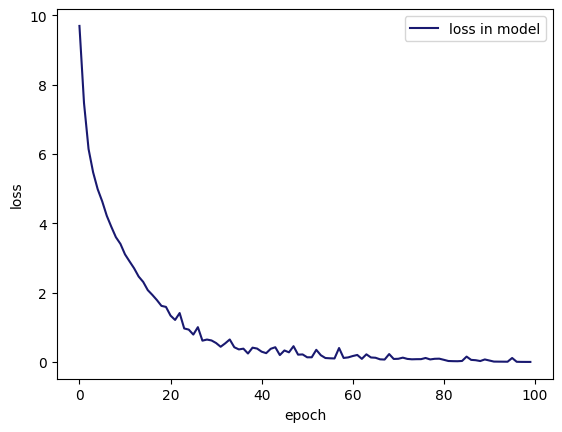

In [17]:
plt.plot(loss_list,label='loss in model',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

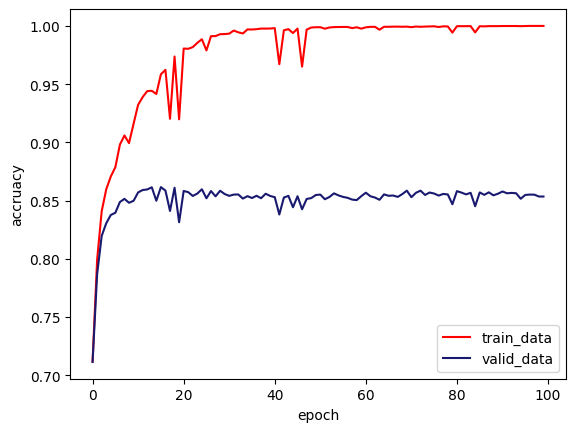

In [18]:
plt.plot(train_acc_list,label='train_data',color='red')
plt.plot(valid_acc_list,label='valid_data',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('accruacy')
plt.legend()
plt.show()

$\huge \text{Trying different number of layers:}$

In [19]:
hidden_size=100
output_size=1
n_layers=2
embedding_dim=64
model=LSTM(hidden_size,output_size,n_layers,embedding_dim).to(device)
criterion =nn.BCELoss()
lr=0.0001
train_acc_list=[]
valid_acc_list=[]
loss_list=[]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs=60
num_epochs=tqdm(range(epochs))

# n_epochs=tqdm(range(epochs))
for epoch in num_epochs:

    running_loss = 0

    for i,(instances, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        instances=instances.to(device)
        labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
        # print(instances.shape)
        output = model(instances)
        loss = criterion(output, labels)


        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_list.append(running_loss/batch_size)
    a=train_acc(model)
    train_acc_list.append(a)
    
    b=valid_acc(model)
    
    # print('accuracy over validation data set:',b)
    valid_acc_list.append(b)
    print('epoch is:',epoch+1,'accuracy over training/validation data set:',a,'/',b,' || running loss is:',running_loss/batch_size)
 


  2%|▏         | 1/60 [00:18<18:18, 18.62s/it]

epoch is: 1 accuracy over training/validation data set: 0.7254933333333333 / 0.7268  || running loss is: 9.683455067276954


  3%|▎         | 2/60 [00:37<18:11, 18.82s/it]

epoch is: 2 accuracy over training/validation data set: 0.78456 / 0.77896  || running loss is: 7.653696845769883


  5%|▌         | 3/60 [00:56<17:45, 18.70s/it]

epoch is: 3 accuracy over training/validation data set: 0.83128 / 0.81544  || running loss is: 6.397627996206284


  7%|▋         | 4/60 [01:14<17:21, 18.59s/it]

epoch is: 4 accuracy over training/validation data set: 0.8542133333333334 / 0.83008  || running loss is: 5.565642579197884


  8%|▊         | 5/60 [01:32<16:54, 18.44s/it]

epoch is: 5 accuracy over training/validation data set: 0.8223733333333333 / 0.80368  || running loss is: 5.014295551180839


 10%|█         | 6/60 [01:51<16:32, 18.38s/it]

epoch is: 6 accuracy over training/validation data set: 0.8831733333333334 / 0.8424  || running loss is: 4.601184972971677


 12%|█▏        | 7/60 [02:09<16:12, 18.34s/it]

epoch is: 7 accuracy over training/validation data set: 0.8905333333333333 / 0.84224  || running loss is: 4.2299685008823875


 13%|█▎        | 8/60 [02:27<15:52, 18.32s/it]

epoch is: 8 accuracy over training/validation data set: 0.906 / 0.852  || running loss is: 3.8997895693778992


 15%|█▌        | 9/60 [02:45<15:34, 18.33s/it]

epoch is: 9 accuracy over training/validation data set: 0.8956 / 0.84512  || running loss is: 3.6538111880421638


 17%|█▋        | 10/60 [03:04<15:21, 18.42s/it]

epoch is: 10 accuracy over training/validation data set: 0.92256 / 0.8572  || running loss is: 3.389011326506734


 18%|█▊        | 11/60 [03:22<14:57, 18.33s/it]

epoch is: 11 accuracy over training/validation data set: 0.9316 / 0.8592  || running loss is: 3.1490636721998455


 20%|██        | 12/60 [03:40<14:39, 18.32s/it]

epoch is: 12 accuracy over training/validation data set: 0.9393333333333334 / 0.85776  || running loss is: 2.886428650841117


 22%|██▏       | 13/60 [03:59<14:26, 18.43s/it]

epoch is: 13 accuracy over training/validation data set: 0.92992 / 0.8476  || running loss is: 2.6637630542367696


 23%|██▎       | 14/60 [04:18<14:07, 18.41s/it]

epoch is: 14 accuracy over training/validation data set: 0.9365333333333333 / 0.84976  || running loss is: 2.465699580051005


 25%|██▌       | 15/60 [04:36<13:50, 18.44s/it]

epoch is: 15 accuracy over training/validation data set: 0.9539466666666667 / 0.85768  || running loss is: 2.326679504737258


 27%|██▋       | 16/60 [04:55<13:34, 18.51s/it]

epoch is: 16 accuracy over training/validation data set: 0.9599466666666666 / 0.85968  || running loss is: 2.114598880968988


 28%|██▊       | 17/60 [05:13<13:12, 18.44s/it]

epoch is: 17 accuracy over training/validation data set: 0.96624 / 0.85976  || running loss is: 1.9316819535195828


 30%|███       | 18/60 [05:42<15:04, 21.53s/it]

epoch is: 18 accuracy over training/validation data set: 0.9671466666666667 / 0.85712  || running loss is: 1.7603437093272805


 32%|███▏      | 19/60 [06:11<16:24, 24.02s/it]

epoch is: 19 accuracy over training/validation data set: 0.9539733333333333 / 0.8456  || running loss is: 1.5926981389150023


 33%|███▎      | 20/60 [06:42<17:13, 25.85s/it]

epoch is: 20 accuracy over training/validation data set: 0.9741333333333333 / 0.85424  || running loss is: 1.47805254554376


 35%|███▌      | 21/60 [07:12<17:37, 27.12s/it]

epoch is: 21 accuracy over training/validation data set: 0.97728 / 0.85232  || running loss is: 1.350496162995696


 37%|███▋      | 22/60 [07:42<17:44, 28.00s/it]

epoch is: 22 accuracy over training/validation data set: 0.9823466666666667 / 0.85608  || running loss is: 1.1369485672190784


 38%|███▊      | 23/60 [08:12<17:38, 28.61s/it]

epoch is: 23 accuracy over training/validation data set: 0.9745333333333334 / 0.84824  || running loss is: 1.1152650576736778


 40%|████      | 24/60 [08:42<17:25, 29.03s/it]

epoch is: 24 accuracy over training/validation data set: 0.988 / 0.85528  || running loss is: 0.9917540993727744


 42%|████▏     | 25/60 [09:12<17:08, 29.37s/it]

epoch is: 25 accuracy over training/validation data set: 0.9881866666666667 / 0.85368  || running loss is: 0.9857947723567486


 43%|████▎     | 26/60 [09:42<16:47, 29.63s/it]

epoch is: 26 accuracy over training/validation data set: 0.9890933333333334 / 0.85064  || running loss is: 0.7812564212689176


 45%|████▌     | 27/60 [10:12<16:22, 29.78s/it]

epoch is: 27 accuracy over training/validation data set: 0.9875466666666667 / 0.84672  || running loss is: 0.7032545181806199


 47%|████▋     | 28/60 [10:42<15:53, 29.81s/it]

epoch is: 28 accuracy over training/validation data set: 0.99312 / 0.85272  || running loss is: 0.7061586310900748


 48%|████▊     | 29/60 [11:12<15:25, 29.87s/it]

epoch is: 29 accuracy over training/validation data set: 0.9906133333333333 / 0.84624  || running loss is: 0.6752205012412742


 50%|█████     | 30/60 [11:42<14:58, 29.96s/it]

epoch is: 30 accuracy over training/validation data set: 0.9948 / 0.85144  || running loss is: 0.5765172988409176


 52%|█████▏    | 31/60 [12:13<14:34, 30.17s/it]

epoch is: 31 accuracy over training/validation data set: 0.9944533333333333 / 0.85168  || running loss is: 0.5867554310942069


 53%|█████▎    | 32/60 [12:43<14:07, 30.25s/it]

epoch is: 32 accuracy over training/validation data set: 0.9960533333333333 / 0.85224  || running loss is: 0.4262033812352456


 55%|█████▌    | 33/60 [13:14<13:37, 30.27s/it]

epoch is: 33 accuracy over training/validation data set: 0.9960266666666666 / 0.8496  || running loss is: 0.44179250034736467


 57%|█████▋    | 34/60 [13:44<13:05, 30.20s/it]

epoch is: 34 accuracy over training/validation data set: 0.9969066666666667 / 0.84936  || running loss is: 0.37531414970057086


 58%|█████▊    | 35/60 [14:11<12:14, 29.36s/it]

epoch is: 35 accuracy over training/validation data set: 0.99696 / 0.85336  || running loss is: 0.443589779472677


 60%|██████    | 36/60 [14:42<11:57, 29.89s/it]

epoch is: 36 accuracy over training/validation data set: 0.99744 / 0.8516  || running loss is: 0.35465516163443683


 62%|██████▏   | 37/60 [15:13<11:34, 30.21s/it]

epoch is: 37 accuracy over training/validation data set: 0.9941333333333333 / 0.84888  || running loss is: 0.3611176111723762


 63%|██████▎   | 38/60 [15:44<11:09, 30.45s/it]

epoch is: 38 accuracy over training/validation data set: 0.9972 / 0.85328  || running loss is: 0.44922397936927155


 65%|██████▌   | 39/60 [16:15<10:43, 30.64s/it]

epoch is: 39 accuracy over training/validation data set: 0.9970133333333333 / 0.8512  || running loss is: 0.22141675554565154


 67%|██████▋   | 40/60 [16:46<10:14, 30.71s/it]

epoch is: 40 accuracy over training/validation data set: 0.99792 / 0.85032  || running loss is: 0.33006939737591895


 68%|██████▊   | 41/60 [17:19<09:53, 31.22s/it]

epoch is: 41 accuracy over training/validation data set: 0.9922933333333334 / 0.8444  || running loss is: 0.3443904883216601


 70%|███████   | 42/60 [17:50<09:21, 31.20s/it]

epoch is: 42 accuracy over training/validation data set: 0.99552 / 0.84248  || running loss is: 0.2102167327993084


 72%|███████▏  | 43/60 [18:17<08:29, 29.98s/it]

epoch is: 43 accuracy over training/validation data set: 0.9983466666666667 / 0.85424  || running loss is: 0.3412517021747772


 73%|███████▎  | 44/60 [18:49<08:11, 30.69s/it]

epoch is: 44 accuracy over training/validation data set: 0.9957066666666666 / 0.85112  || running loss is: 0.2933940172602888


 75%|███████▌  | 45/60 [19:22<07:49, 31.33s/it]

epoch is: 45 accuracy over training/validation data set: 0.9985866666666666 / 0.85304  || running loss is: 0.19175381385255605


 77%|███████▋  | 46/60 [19:56<07:28, 32.01s/it]

epoch is: 46 accuracy over training/validation data set: 0.99736 / 0.8528  || running loss is: 0.1616009204031434


 78%|███████▊  | 47/60 [20:28<06:57, 32.09s/it]

epoch is: 47 accuracy over training/validation data set: 0.99888 / 0.85448  || running loss is: 0.17401869200228248


 80%|████████  | 48/60 [21:00<06:25, 32.09s/it]

epoch is: 48 accuracy over training/validation data set: 0.9952533333333333 / 0.85008  || running loss is: 0.26530592319963037


 82%|████████▏ | 49/60 [21:32<05:53, 32.11s/it]

epoch is: 49 accuracy over training/validation data set: 0.99888 / 0.85464  || running loss is: 0.19850336561270523


 83%|████████▎ | 50/60 [22:04<05:20, 32.06s/it]

epoch is: 50 accuracy over training/validation data set: 0.99904 / 0.85384  || running loss is: 0.14551163105410525


 85%|████████▌ | 51/60 [22:36<04:47, 31.95s/it]

epoch is: 51 accuracy over training/validation data set: 0.9986133333333334 / 0.8512  || running loss is: 0.17361442345019895


 87%|████████▋ | 52/60 [23:07<04:14, 31.83s/it]

epoch is: 52 accuracy over training/validation data set: 0.9984 / 0.854  || running loss is: 0.2098077909706626


 88%|████████▊ | 53/60 [23:40<03:43, 31.99s/it]

epoch is: 53 accuracy over training/validation data set: 0.9990933333333334 / 0.8568  || running loss is: 0.21957609706092626


 90%|█████████ | 54/60 [24:12<03:11, 31.97s/it]

epoch is: 54 accuracy over training/validation data set: 0.9992266666666667 / 0.85528  || running loss is: 0.08557515766355209


 92%|█████████▏| 55/60 [24:44<02:40, 32.01s/it]

epoch is: 55 accuracy over training/validation data set: 0.9984533333333333 / 0.8516  || running loss is: 0.22966501925780902


 93%|█████████▎| 56/60 [25:16<02:08, 32.08s/it]

epoch is: 56 accuracy over training/validation data set: 0.99928 / 0.8524  || running loss is: 0.17740953810221982


 95%|█████████▌| 57/60 [25:48<01:36, 32.04s/it]

epoch is: 57 accuracy over training/validation data set: 0.99936 / 0.85176  || running loss is: 0.16213741930376271


 97%|█████████▋| 58/60 [26:20<01:03, 31.95s/it]

epoch is: 58 accuracy over training/validation data set: 0.9994933333333333 / 0.85312  || running loss is: 0.07842222480365307


 98%|█████████▊| 59/60 [26:51<00:31, 31.88s/it]

epoch is: 59 accuracy over training/validation data set: 0.9995466666666667 / 0.85304  || running loss is: 0.054957318822271194


100%|██████████| 60/60 [27:23<00:00, 27.40s/it]

epoch is: 60 accuracy over training/validation data set: 0.99776 / 0.852  || running loss is: 0.26002375178650255


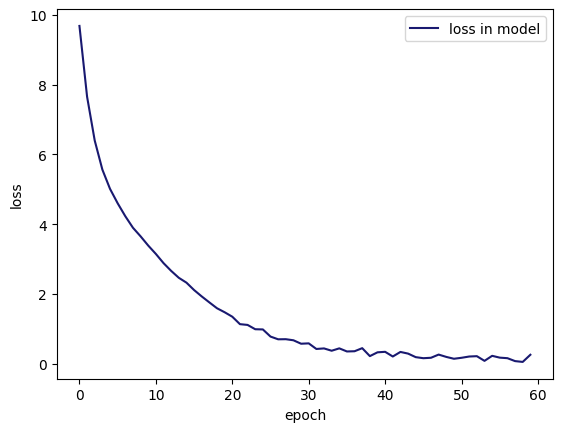

In [20]:
plt.plot(loss_list,label='loss in model',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

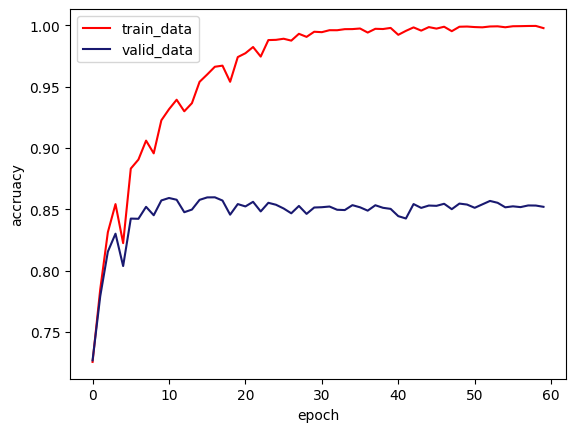

In [21]:
plt.plot(train_acc_list,label='train_data',color='red')
plt.plot(valid_acc_list,label='valid_data',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('accruacy')
plt.legend()
plt.show()

$\large \text{Using differenet embedding dimensions:}$

In [22]:
hidden_size=100
output_size=1
n_layers=1
embedding_dim=256
model=LSTM(hidden_size,output_size,n_layers,embedding_dim).to(device)
criterion =nn.BCELoss()
lr=0.0001
train_acc_list=[]
valid_acc_list=[]
loss_list=[]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs=100
num_epochs=tqdm(range(epochs))

# n_epochs=tqdm(range(epochs))
for epoch in num_epochs:

    running_loss = 0

    for i,(instances, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        instances=instances.to(device)
        labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
        # print(instances.shape)
        output = model(instances)
        loss = criterion(output, labels)


        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_list.append(running_loss/batch_size)
    a=train_acc(model)
    train_acc_list.append(a)
    
    b=valid_acc(model)
    
    # print('accuracy over validation data set:',b)
    valid_acc_list.append(b)
    print('epoch is:',epoch+1,'accuracy over training/validation data set:',a,'/',b,' || running loss is:',running_loss/batch_size)
 


  1%|          | 1/100 [00:31<52:27, 31.79s/it]

epoch is: 1 accuracy over training/validation data set: 0.7277333333333333 / 0.71488  || running loss is: 9.985541277527808


  2%|▏         | 2/100 [01:03<51:48, 31.72s/it]

epoch is: 2 accuracy over training/validation data set: 0.84936 / 0.8244  || running loss is: 6.774842827320099


  3%|▎         | 3/100 [01:35<51:26, 31.82s/it]

epoch is: 3 accuracy over training/validation data set: 0.8862133333333333 / 0.85256  || running loss is: 5.224674628674984


  4%|▍         | 4/100 [02:06<50:44, 31.72s/it]

epoch is: 4 accuracy over training/validation data set: 0.9088 / 0.8636  || running loss is: 4.297110995054245


  5%|▌         | 5/100 [02:38<50:15, 31.74s/it]

epoch is: 5 accuracy over training/validation data set: 0.92088 / 0.86096  || running loss is: 3.6407811062037947


  6%|▌         | 6/100 [03:10<49:40, 31.71s/it]

epoch is: 6 accuracy over training/validation data set: 0.94072 / 0.8712  || running loss is: 3.086184754893184


  7%|▋         | 7/100 [03:42<49:10, 31.73s/it]

epoch is: 7 accuracy over training/validation data set: 0.9505866666666667 / 0.87392  || running loss is: 2.6595012269541622


  8%|▊         | 8/100 [04:13<48:41, 31.75s/it]

epoch is: 8 accuracy over training/validation data set: 0.9606933333333333 / 0.8724  || running loss is: 2.2333880653977394


  9%|▉         | 9/100 [04:45<48:05, 31.71s/it]

epoch is: 9 accuracy over training/validation data set: 0.9682933333333333 / 0.87248  || running loss is: 1.9417742094770074


 10%|█         | 10/100 [05:17<47:33, 31.70s/it]

epoch is: 10 accuracy over training/validation data set: 0.97536 / 0.87216  || running loss is: 1.5843111499771476


 11%|█         | 11/100 [05:48<46:48, 31.56s/it]

epoch is: 11 accuracy over training/validation data set: 0.98064 / 0.87232  || running loss is: 1.3788843241892754


 12%|█▏        | 12/100 [06:20<46:34, 31.75s/it]

epoch is: 12 accuracy over training/validation data set: 0.9829333333333333 / 0.87192  || running loss is: 1.188759186193347


 13%|█▎        | 13/100 [06:51<45:48, 31.60s/it]

epoch is: 13 accuracy over training/validation data set: 0.9887466666666667 / 0.87336  || running loss is: 0.946257667215541


 14%|█▍        | 14/100 [07:23<45:20, 31.64s/it]

epoch is: 14 accuracy over training/validation data set: 0.9907466666666667 / 0.87168  || running loss is: 0.8977355770114809


 15%|█▌        | 15/100 [07:53<43:56, 31.02s/it]

epoch is: 15 accuracy over training/validation data set: 0.9928266666666666 / 0.87048  || running loss is: 0.6750896186800673


 16%|█▌        | 16/100 [08:26<44:25, 31.73s/it]

epoch is: 16 accuracy over training/validation data set: 0.9937333333333334 / 0.87104  || running loss is: 0.6084240972157567


 17%|█▋        | 17/100 [08:59<44:29, 32.16s/it]

epoch is: 17 accuracy over training/validation data set: 0.9955466666666667 / 0.8712  || running loss is: 0.48917748922947796


 18%|█▊        | 18/100 [09:33<44:24, 32.50s/it]

epoch is: 18 accuracy over training/validation data set: 0.9952533333333333 / 0.86744  || running loss is: 0.4110247688763775


 19%|█▉        | 19/100 [10:06<44:22, 32.87s/it]

epoch is: 19 accuracy over training/validation data set: 0.9954133333333334 / 0.86688  || running loss is: 0.3615454859926831


 20%|██        | 20/100 [10:40<44:01, 33.02s/it]

epoch is: 20 accuracy over training/validation data set: 0.9965333333333334 / 0.86696  || running loss is: 0.3617941163969226


 21%|██        | 21/100 [11:13<43:37, 33.13s/it]

epoch is: 21 accuracy over training/validation data set: 0.9979466666666666 / 0.86872  || running loss is: 0.26314932961715387


 22%|██▏       | 22/100 [11:47<43:14, 33.26s/it]

epoch is: 22 accuracy over training/validation data set: 0.9982133333333333 / 0.87104  || running loss is: 0.25758811954408883


 23%|██▎       | 23/100 [12:20<42:51, 33.40s/it]

epoch is: 23 accuracy over training/validation data set: 0.99752 / 0.86912  || running loss is: 0.3405516122491099


 24%|██▍       | 24/100 [12:54<42:27, 33.51s/it]

epoch is: 24 accuracy over training/validation data set: 0.9988533333333334 / 0.8696  || running loss is: 0.15893081875052303


 25%|██▌       | 25/100 [13:27<41:47, 33.44s/it]

epoch is: 25 accuracy over training/validation data set: 0.9976 / 0.86176  || running loss is: 0.11184181067714234


 26%|██▌       | 26/100 [14:01<41:14, 33.44s/it]

epoch is: 26 accuracy over training/validation data set: 0.9989066666666667 / 0.86664  || running loss is: 0.12451711128873284


 27%|██▋       | 27/100 [14:34<40:40, 33.43s/it]

epoch is: 27 accuracy over training/validation data set: 0.9991466666666666 / 0.86888  || running loss is: 0.16992032682988792


 28%|██▊       | 28/100 [15:08<40:09, 33.47s/it]

epoch is: 28 accuracy over training/validation data set: 0.99672 / 0.86192  || running loss is: 0.1449121351123904


 29%|██▉       | 29/100 [15:41<39:30, 33.39s/it]

epoch is: 29 accuracy over training/validation data set: 0.9995466666666667 / 0.86944  || running loss is: 0.14612989521381678


 30%|███       | 30/100 [16:14<38:53, 33.33s/it]

epoch is: 30 accuracy over training/validation data set: 0.9994133333333334 / 0.86672  || running loss is: 0.08723402601724956


 31%|███       | 31/100 [16:47<38:18, 33.32s/it]

epoch is: 31 accuracy over training/validation data set: 0.99976 / 0.86856  || running loss is: 0.061643623792624565


 32%|███▏      | 32/100 [17:21<37:44, 33.31s/it]

epoch is: 32 accuracy over training/validation data set: 0.9998133333333333 / 0.86792  || running loss is: 0.03441191628240631


 33%|███▎      | 33/100 [17:54<37:06, 33.24s/it]

epoch is: 33 accuracy over training/validation data set: 0.9988533333333334 / 0.86272  || running loss is: 0.15323074817992166


 34%|███▍      | 34/100 [18:27<36:29, 33.17s/it]

epoch is: 34 accuracy over training/validation data set: 0.9997866666666667 / 0.86568  || running loss is: 0.09653258217091207


 35%|███▌      | 35/100 [19:00<35:51, 33.11s/it]

epoch is: 35 accuracy over training/validation data set: 0.99968 / 0.86728  || running loss is: 0.061861383367504456


 36%|███▌      | 36/100 [19:32<34:58, 32.78s/it]

epoch is: 36 accuracy over training/validation data set: 0.9996533333333333 / 0.86392  || running loss is: 0.10169115585376858


 37%|███▋      | 37/100 [20:06<34:42, 33.05s/it]

epoch is: 37 accuracy over training/validation data set: 0.9998133333333333 / 0.8656  || running loss is: 0.06314599536490277


 38%|███▊      | 38/100 [20:39<34:17, 33.19s/it]

epoch is: 38 accuracy over training/validation data set: 0.9990133333333333 / 0.86848  || running loss is: 0.3134768131433521


 39%|███▉      | 39/100 [21:13<33:52, 33.31s/it]

epoch is: 39 accuracy over training/validation data set: 0.9998133333333333 / 0.86768  || running loss is: 0.037716605100868036


 40%|████      | 40/100 [21:49<34:09, 34.17s/it]

epoch is: 40 accuracy over training/validation data set: 0.9998933333333333 / 0.86872  || running loss is: 0.0247659535161074


 41%|████      | 41/100 [22:21<33:06, 33.67s/it]

epoch is: 41 accuracy over training/validation data set: 0.9998933333333333 / 0.86752  || running loss is: 0.011695275440361001


 42%|████▏     | 42/100 [22:53<32:06, 33.22s/it]

epoch is: 42 accuracy over training/validation data set: 0.9999466666666667 / 0.86688  || running loss is: 0.008881874861617688


 43%|████▎     | 43/100 [23:30<32:32, 34.25s/it]

epoch is: 43 accuracy over training/validation data set: 0.9992266666666667 / 0.8668  || running loss is: 0.3408992513865451


 44%|████▍     | 44/100 [24:03<31:26, 33.69s/it]

epoch is: 44 accuracy over training/validation data set: 0.9999733333333334 / 0.87  || running loss is: 0.03704992024569947


 45%|████▌     | 45/100 [24:34<30:14, 32.99s/it]

epoch is: 45 accuracy over training/validation data set: 0.9999733333333334 / 0.86768  || running loss is: 0.011872556723828894


 46%|████▌     | 46/100 [25:04<28:50, 32.05s/it]

epoch is: 46 accuracy over training/validation data set: 0.9999733333333334 / 0.86832  || running loss is: 0.007817576632696728


 47%|████▋     | 47/100 [25:33<27:42, 31.36s/it]

epoch is: 47 accuracy over training/validation data set: 0.9999733333333334 / 0.86888  || running loss is: 0.006741740449851932


 48%|████▊     | 48/100 [26:05<27:08, 31.33s/it]

epoch is: 48 accuracy over training/validation data set: 0.9999733333333334 / 0.8684  || running loss is: 0.004678229568762618


 49%|████▉     | 49/100 [26:36<26:40, 31.39s/it]

epoch is: 49 accuracy over training/validation data set: 0.9999733333333334 / 0.86728  || running loss is: 0.003345726360585104


 50%|█████     | 50/100 [27:07<26:06, 31.34s/it]

epoch is: 50 accuracy over training/validation data set: 0.99904 / 0.864  || running loss is: 0.2054138555222744


 51%|█████     | 51/100 [27:38<25:22, 31.06s/it]

epoch is: 51 accuracy over training/validation data set: 0.99992 / 0.87032  || running loss is: 0.07638407874637779


 52%|█████▏    | 52/100 [28:10<25:04, 31.34s/it]

epoch is: 52 accuracy over training/validation data set: 0.9988266666666666 / 0.86272  || running loss is: 0.01913751783566113


 53%|█████▎    | 53/100 [28:39<24:07, 30.81s/it]

epoch is: 53 accuracy over training/validation data set: 0.9997866666666667 / 0.8688  || running loss is: 0.04251659543149799


 54%|█████▍    | 54/100 [29:13<24:10, 31.54s/it]

epoch is: 54 accuracy over training/validation data set: 0.9998933333333333 / 0.8712  || running loss is: 0.13061046859515046


 55%|█████▌    | 55/100 [29:46<23:58, 31.97s/it]

epoch is: 55 accuracy over training/validation data set: 0.9996266666666667 / 0.86976  || running loss is: 0.01749894118460361


 56%|█████▌    | 56/100 [30:19<23:40, 32.29s/it]

epoch is: 56 accuracy over training/validation data set: 1.0 / 0.87072  || running loss is: 0.010109293246423477


 57%|█████▋    | 57/100 [30:51<23:13, 32.40s/it]

epoch is: 57 accuracy over training/validation data set: 0.99992 / 0.86936  || running loss is: 0.0029446031907173166


 58%|█████▊    | 58/100 [31:21<22:11, 31.71s/it]

epoch is: 58 accuracy over training/validation data set: 0.9385333333333333 / 0.82312  || running loss is: 0.1743901294366151


 59%|█████▉    | 59/100 [31:40<19:00, 27.82s/it]

epoch is: 59 accuracy over training/validation data set: 0.9999466666666667 / 0.86952  || running loss is: 0.22840095326901064


 60%|██████    | 60/100 [31:59<16:44, 25.11s/it]

epoch is: 60 accuracy over training/validation data set: 0.9998133333333333 / 0.87024  || running loss is: 0.024891953857113548


 61%|██████    | 61/100 [32:18<15:06, 23.25s/it]

epoch is: 61 accuracy over training/validation data set: 1.0 / 0.87136  || running loss is: 0.016246674812136916


 62%|██████▏   | 62/100 [32:37<13:54, 21.96s/it]

epoch is: 62 accuracy over training/validation data set: 1.0 / 0.8708  || running loss is: 0.011597113864572748


 63%|██████▎   | 63/100 [32:56<13:00, 21.10s/it]

epoch is: 63 accuracy over training/validation data set: 1.0 / 0.87064  || running loss is: 0.004377405822742731


 64%|██████▍   | 64/100 [33:12<11:49, 19.70s/it]

epoch is: 64 accuracy over training/validation data set: 1.0 / 0.87088  || running loss is: 0.0025765705336925748


 65%|██████▌   | 65/100 [33:31<11:19, 19.41s/it]

epoch is: 65 accuracy over training/validation data set: 1.0 / 0.86944  || running loss is: 0.0018107578867056873


 66%|██████▌   | 66/100 [33:51<11:01, 19.45s/it]

epoch is: 66 accuracy over training/validation data set: 1.0 / 0.86848  || running loss is: 0.0014027482308483742


 67%|██████▋   | 67/100 [34:09<10:33, 19.21s/it]

epoch is: 67 accuracy over training/validation data set: 0.9972533333333333 / 0.86144  || running loss is: 0.1614895478886615


 68%|██████▊   | 68/100 [34:28<10:11, 19.11s/it]

epoch is: 68 accuracy over training/validation data set: 0.99728 / 0.85568  || running loss is: 0.03684538358476857


 69%|██████▉   | 69/100 [34:47<09:46, 18.92s/it]

epoch is: 69 accuracy over training/validation data set: 1.0 / 0.86712  || running loss is: 0.008386528646842634


 70%|███████   | 70/100 [35:05<09:24, 18.83s/it]

epoch is: 70 accuracy over training/validation data set: 1.0 / 0.86656  || running loss is: 0.0020097255320797557


 71%|███████   | 71/100 [35:24<09:03, 18.75s/it]

epoch is: 71 accuracy over training/validation data set: 1.0 / 0.86616  || running loss is: 0.0014580985572274585


 72%|███████▏  | 72/100 [35:42<08:42, 18.65s/it]

epoch is: 72 accuracy over training/validation data set: 1.0 / 0.86584  || running loss is: 0.0011230948729576084


 73%|███████▎  | 73/100 [36:01<08:24, 18.68s/it]

epoch is: 73 accuracy over training/validation data set: 0.9932 / 0.85816  || running loss is: 0.15445911839437484


 74%|███████▍  | 74/100 [36:20<08:04, 18.63s/it]

epoch is: 74 accuracy over training/validation data set: 1.0 / 0.87112  || running loss is: 0.06231784130892265


 75%|███████▌  | 75/100 [36:38<07:45, 18.64s/it]

epoch is: 75 accuracy over training/validation data set: 1.0 / 0.872  || running loss is: 0.002885694289698222


 76%|███████▌  | 76/100 [36:57<07:26, 18.61s/it]

epoch is: 76 accuracy over training/validation data set: 0.99944 / 0.86808  || running loss is: 0.044887150965096226


 77%|███████▋  | 77/100 [37:16<07:12, 18.80s/it]

epoch is: 77 accuracy over training/validation data set: 0.9999733333333334 / 0.87176  || running loss is: 0.05020783021183888


 78%|███████▊  | 78/100 [37:35<06:56, 18.94s/it]

epoch is: 78 accuracy over training/validation data set: 1.0 / 0.87144  || running loss is: 0.003378965955644162


 79%|███████▉  | 79/100 [37:54<06:37, 18.91s/it]

epoch is: 79 accuracy over training/validation data set: 1.0 / 0.8696  || running loss is: 0.004299200116220163


 80%|████████  | 80/100 [38:13<06:16, 18.82s/it]

epoch is: 80 accuracy over training/validation data set: 1.0 / 0.86984  || running loss is: 0.0015230276590864377


 81%|████████  | 81/100 [38:31<05:56, 18.79s/it]

epoch is: 81 accuracy over training/validation data set: 0.99544 / 0.85744  || running loss is: 0.006411018979101755


 82%|████████▏ | 82/100 [38:50<05:37, 18.76s/it]

epoch is: 82 accuracy over training/validation data set: 0.9998133333333333 / 0.87  || running loss is: 0.13271695755282054


 83%|████████▎ | 83/100 [39:09<05:19, 18.79s/it]

epoch is: 83 accuracy over training/validation data set: 0.9996 / 0.86832  || running loss is: 0.03239872829421074


 84%|████████▍ | 84/100 [39:28<05:00, 18.79s/it]

epoch is: 84 accuracy over training/validation data set: 1.0 / 0.87008  || running loss is: 0.011820394152891822


 85%|████████▌ | 85/100 [39:48<04:48, 19.26s/it]

epoch is: 85 accuracy over training/validation data set: 0.9999733333333334 / 0.87072  || running loss is: 0.08391031545339502


 86%|████████▌ | 86/100 [40:08<04:33, 19.54s/it]

epoch is: 86 accuracy over training/validation data set: 0.9999733333333334 / 0.86856  || running loss is: 0.00484873554164551


 87%|████████▋ | 87/100 [40:29<04:17, 19.79s/it]

epoch is: 87 accuracy over training/validation data set: 0.99968 / 0.86552  || running loss is: 0.06298475768144271


 88%|████████▊ | 88/100 [40:49<03:59, 19.97s/it]

epoch is: 88 accuracy over training/validation data set: 0.9999733333333334 / 0.87064  || running loss is: 0.1075847971604344


 89%|████████▉ | 89/100 [41:08<03:35, 19.62s/it]

epoch is: 89 accuracy over training/validation data set: 1.0 / 0.87328  || running loss is: 0.006007299412085558


 90%|█████████ | 90/100 [41:26<03:12, 19.30s/it]

epoch is: 90 accuracy over training/validation data set: 1.0 / 0.87216  || running loss is: 0.0016134348541345389


 91%|█████████ | 91/100 [41:45<02:51, 19.07s/it]

epoch is: 91 accuracy over training/validation data set: 0.9999733333333334 / 0.87232  || running loss is: 0.0010854296120623985


 92%|█████████▏| 92/100 [42:03<02:30, 18.85s/it]

epoch is: 92 accuracy over training/validation data set: 0.9984 / 0.86064  || running loss is: 0.06686646572558402


 93%|█████████▎| 93/100 [42:22<02:11, 18.79s/it]

epoch is: 93 accuracy over training/validation data set: 0.9997333333333334 / 0.86656  || running loss is: 0.01598783706289396


 94%|█████████▍| 94/100 [42:38<01:47, 17.98s/it]

epoch is: 94 accuracy over training/validation data set: 0.99944 / 0.86704  || running loss is: 0.057874541617748035


 95%|█████████▌| 95/100 [42:57<01:30, 18.19s/it]

epoch is: 95 accuracy over training/validation data set: 0.9981066666666667 / 0.86312  || running loss is: 0.08086352082966186


 96%|█████████▌| 96/100 [43:15<01:13, 18.31s/it]

epoch is: 96 accuracy over training/validation data set: 1.0 / 0.8704  || running loss is: 0.027597064686306114


 97%|█████████▋| 97/100 [43:34<00:55, 18.41s/it]

epoch is: 97 accuracy over training/validation data set: 1.0 / 0.86936  || running loss is: 0.00257390261063847


 98%|█████████▊| 98/100 [43:53<00:36, 18.49s/it]

epoch is: 98 accuracy over training/validation data set: 1.0 / 0.86912  || running loss is: 0.0012824041819931152


 99%|█████████▉| 99/100 [44:11<00:18, 18.54s/it]

epoch is: 99 accuracy over training/validation data set: 1.0 / 0.86864  || running loss is: 0.0008858438168431349


100%|██████████| 100/100 [44:27<00:00, 26.68s/it]

epoch is: 100 accuracy over training/validation data set: 1.0 / 0.86832  || running loss is: 0.0006784789013886439


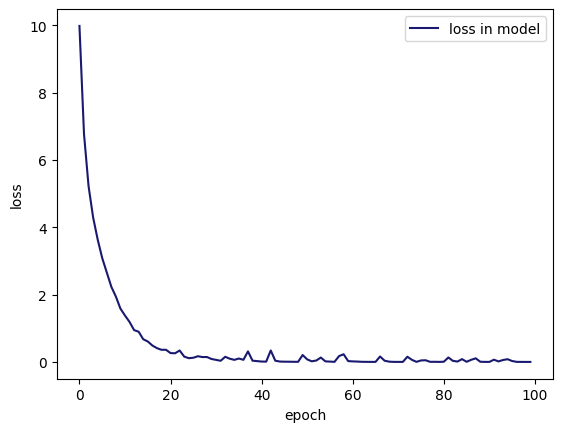

In [23]:
plt.plot(loss_list,label='loss in model',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

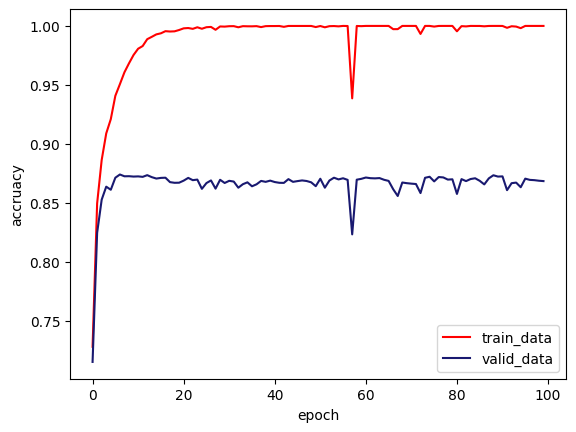

In [24]:
plt.plot(train_acc_list,label='train_data',color='red')
plt.plot(valid_acc_list,label='valid_data',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('accruacy')
plt.legend()
plt.show()

$\large \text{Hence we can see that our model is clearly overfitting in each variant so now we try regularization and other variants:}$

$\huge \text{Weight Initialization with normal 0,1}$

In [25]:
# Define the RNN model
class LSTM(nn.Module):
    def __init__(self, hidden_size, output_size,n_layers,embedding_dim):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers=n_layers
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_size,
                           num_layers=self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu=nn.ReLU()
        self.sigmoid=nn.Sigmoid()
        self.tanh=nn.Tanh()
        self.embed=nn.Embedding(len(vocab)+1,embedding_dim=embedding_dim)
    def forward(self, x):
       
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embed(x)
        # pass in the rnn layer
        output,hidden=self.lstm(embeds)
        
        
        output=output.contiguous().view(-1,self.hidden_size)
        
        output = self.sigmoid(self.fc(output))
        output=output.view(batch_size,-1)
        
        output=output[:,-1].view(batch_size,-1)
        
        return output

    def init_hidden(self,batch_size):
        hidden=torch.zeros(self.n_layers,batch_size,self.hidden_size).to(device)
        return hidden
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()

In [26]:
hidden_size=100
output_size=1
n_layers=1
embedding_dim=64
model=LSTM(hidden_size,output_size,n_layers,embedding_dim).to(device)
criterion =nn.BCELoss()
lr=0.0001
train_acc_list=[]
valid_acc_list=[]
loss_list=[]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs=100
num_epochs=tqdm(range(epochs))

# n_epochs=tqdm(range(epochs))
for epoch in num_epochs:

    running_loss = 0

    for i,(instances, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        instances=instances.to(device)
        labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
        # print(instances.shape)
        output = model(instances)

        # print(labels.shape)
        # print(output.shape)
        # print(output)

        # print(output.shape)
        # print(labels.shape)
        loss = criterion(output, labels)


        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_list.append(running_loss/batch_size)
    a=train_acc(model)
    train_acc_list.append(a)
    
    b=valid_acc(model)
    
    # print('accuracy over validation data set:',b)
    valid_acc_list.append(b)
    print('epoch is:',epoch+1,'accuracy over training/validation data set:',a,'/',b,' || running loss is:',running_loss/batch_size)
 


  0%|          | 0/100 [00:00<?, ?it/s]  1%|          | 1/100 [00:14<24:04, 14.59s/it]

epoch is: 1 accuracy over training/validation data set: 0.63992 / 0.6308  || running loss is: 10.26162850856781


  2%|▏         | 2/100 [00:29<23:49, 14.59s/it]

epoch is: 2 accuracy over training/validation data set: 0.77512 / 0.7572  || running loss is: 8.400991990566254


  3%|▎         | 3/100 [00:43<23:20, 14.44s/it]

epoch is: 3 accuracy over training/validation data set: 0.8180266666666667 / 0.80096  || running loss is: 6.900491734147072


  4%|▍         | 4/100 [00:58<23:14, 14.52s/it]

epoch is: 4 accuracy over training/validation data set: 0.8458666666666667 / 0.82232  || running loss is: 5.9727914583683015


  5%|▌         | 5/100 [01:12<22:59, 14.52s/it]

epoch is: 5 accuracy over training/validation data set: 0.86376 / 0.83392  || running loss is: 5.337084786295891


  6%|▌         | 6/100 [01:27<22:43, 14.51s/it]

epoch is: 6 accuracy over training/validation data set: 0.8776266666666667 / 0.84312  || running loss is: 4.888012757301331


  7%|▋         | 7/100 [01:41<22:31, 14.53s/it]

epoch is: 7 accuracy over training/validation data set: 0.8844533333333333 / 0.84456  || running loss is: 4.514555236846209


  8%|▊         | 8/100 [01:56<22:13, 14.49s/it]

epoch is: 8 accuracy over training/validation data set: 0.8981333333333333 / 0.85424  || running loss is: 4.249779794514179


  9%|▉         | 9/100 [02:10<22:01, 14.52s/it]

epoch is: 9 accuracy over training/validation data set: 0.9067733333333333 / 0.856  || running loss is: 3.902875889763236


 10%|█         | 10/100 [02:25<21:44, 14.49s/it]

epoch is: 10 accuracy over training/validation data set: 0.9131466666666667 / 0.85704  || running loss is: 3.7136949567496775


 11%|█         | 11/100 [02:39<21:29, 14.49s/it]

epoch is: 11 accuracy over training/validation data set: 0.9209866666666666 / 0.85824  || running loss is: 3.4370029285550117


 12%|█▏        | 12/100 [02:54<21:17, 14.52s/it]

epoch is: 12 accuracy over training/validation data set: 0.8994133333333333 / 0.84136  || running loss is: 3.2009297665953635


 13%|█▎        | 13/100 [03:08<20:59, 14.48s/it]

epoch is: 13 accuracy over training/validation data set: 0.9323466666666667 / 0.86264  || running loss is: 3.00682402536273


 14%|█▍        | 14/100 [03:23<21:02, 14.68s/it]

epoch is: 14 accuracy over training/validation data set: 0.93888 / 0.86352  || running loss is: 2.8381593132764102


 15%|█▌        | 15/100 [03:38<20:43, 14.63s/it]

epoch is: 15 accuracy over training/validation data set: 0.9452 / 0.86464  || running loss is: 2.6309026584774258


 16%|█▌        | 16/100 [03:52<20:23, 14.56s/it]

epoch is: 16 accuracy over training/validation data set: 0.9498933333333334 / 0.86472  || running loss is: 2.4633547622337937


 17%|█▋        | 17/100 [04:06<20:04, 14.51s/it]

epoch is: 17 accuracy over training/validation data set: 0.9523733333333333 / 0.86528  || running loss is: 2.2926340897381308


 18%|█▊        | 18/100 [04:21<19:47, 14.48s/it]

epoch is: 18 accuracy over training/validation data set: 0.9545866666666667 / 0.86288  || running loss is: 2.1413143565505743


 19%|█▉        | 19/100 [04:36<19:59, 14.81s/it]

epoch is: 19 accuracy over training/validation data set: 0.9629333333333333 / 0.8652  || running loss is: 1.9559140611998738


 20%|██        | 20/100 [04:51<19:46, 14.83s/it]

epoch is: 20 accuracy over training/validation data set: 0.9636266666666666 / 0.86592  || running loss is: 1.8277909390442073


 21%|██        | 21/100 [05:06<19:21, 14.71s/it]

epoch is: 21 accuracy over training/validation data set: 0.9710666666666666 / 0.8648  || running loss is: 1.663950337227434


 22%|██▏       | 22/100 [05:20<19:02, 14.65s/it]

epoch is: 22 accuracy over training/validation data set: 0.9687466666666666 / 0.86352  || running loss is: 1.573318829908967


 23%|██▎       | 23/100 [05:35<18:56, 14.76s/it]

epoch is: 23 accuracy over training/validation data set: 0.9762133333333334 / 0.86616  || running loss is: 1.3988272983767092


 24%|██▍       | 24/100 [05:50<18:40, 14.75s/it]

epoch is: 24 accuracy over training/validation data set: 0.9777066666666666 / 0.8644  || running loss is: 1.344173399154097


 25%|██▌       | 25/100 [06:05<18:27, 14.77s/it]

epoch is: 25 accuracy over training/validation data set: 0.98096 / 0.86312  || running loss is: 1.3010494132712482


 26%|██▌       | 26/100 [06:19<18:07, 14.69s/it]

epoch is: 26 accuracy over training/validation data set: 0.9810133333333333 / 0.86272  || running loss is: 1.0826276603713632


 27%|██▋       | 27/100 [06:34<17:47, 14.62s/it]

epoch is: 27 accuracy over training/validation data set: 0.9745066666666666 / 0.85792  || running loss is: 0.971916926195845


 28%|██▊       | 28/100 [06:49<17:40, 14.72s/it]

epoch is: 28 accuracy over training/validation data set: 0.9823466666666667 / 0.858  || running loss is: 0.9204233717452734


 29%|██▉       | 29/100 [07:03<17:23, 14.70s/it]

epoch is: 29 accuracy over training/validation data set: 0.9833333333333333 / 0.86056  || running loss is: 0.8592186623113229


 30%|███       | 30/100 [07:20<17:53, 15.33s/it]

epoch is: 30 accuracy over training/validation data set: 0.99016 / 0.86168  || running loss is: 0.8163868181873113


 31%|███       | 31/100 [07:35<17:21, 15.09s/it]

epoch is: 31 accuracy over training/validation data set: 0.96904 / 0.85416  || running loss is: 1.1717746990080924


 32%|███▏      | 32/100 [07:49<16:57, 14.96s/it]

epoch is: 32 accuracy over training/validation data set: 0.9920533333333333 / 0.86064  || running loss is: 0.7464154352992773


 33%|███▎      | 33/100 [08:04<16:28, 14.76s/it]

epoch is: 33 accuracy over training/validation data set: 0.9918933333333333 / 0.86192  || running loss is: 0.5923393205692992


 34%|███▍      | 34/100 [08:18<16:08, 14.68s/it]

epoch is: 34 accuracy over training/validation data set: 0.9937333333333334 / 0.8592  || running loss is: 0.5535924764536321


 35%|███▌      | 35/100 [08:35<16:26, 15.17s/it]

epoch is: 35 accuracy over training/validation data set: 0.9942933333333334 / 0.86304  || running loss is: 0.9451658695517108


 36%|███▌      | 36/100 [08:51<16:34, 15.54s/it]

epoch is: 36 accuracy over training/validation data set: 0.9943733333333333 / 0.85904  || running loss is: 0.41323725443566217


 37%|███▋      | 37/100 [09:05<15:58, 15.22s/it]

epoch is: 37 accuracy over training/validation data set: 0.99544 / 0.86136  || running loss is: 0.4738284808839671


 38%|███▊      | 38/100 [09:20<15:28, 14.98s/it]

epoch is: 38 accuracy over training/validation data set: 0.9961066666666667 / 0.86208  || running loss is: 0.37290098051773385


 39%|███▉      | 39/100 [09:34<15:05, 14.85s/it]

epoch is: 39 accuracy over training/validation data set: 0.99616 / 0.85808  || running loss is: 0.3391071092360653


 40%|████      | 40/100 [09:49<14:45, 14.75s/it]

epoch is: 40 accuracy over training/validation data set: 0.99008 / 0.85512  || running loss is: 0.34971925645601004


 41%|████      | 41/100 [10:04<14:29, 14.74s/it]

epoch is: 41 accuracy over training/validation data set: 0.9964 / 0.85768  || running loss is: 0.2799663510429673


 42%|████▏     | 42/100 [10:18<14:15, 14.75s/it]

epoch is: 42 accuracy over training/validation data set: 0.9969333333333333 / 0.85928  || running loss is: 0.3380357501609251


 43%|████▎     | 43/100 [10:33<13:59, 14.73s/it]

epoch is: 43 accuracy over training/validation data set: 0.9972 / 0.85872  || running loss is: 0.3357105642079841


 44%|████▍     | 44/100 [10:48<13:43, 14.71s/it]

epoch is: 44 accuracy over training/validation data set: 0.99832 / 0.86064  || running loss is: 0.18938539094873705


 45%|████▌     | 45/100 [11:02<13:26, 14.67s/it]

epoch is: 45 accuracy over training/validation data set: 0.99848 / 0.8616  || running loss is: 0.2702386532019591


 46%|████▌     | 46/100 [11:17<13:12, 14.68s/it]

epoch is: 46 accuracy over training/validation data set: 0.9967733333333333 / 0.85808  || running loss is: 0.20091395509487484


 47%|████▋     | 47/100 [11:31<12:54, 14.62s/it]

epoch is: 47 accuracy over training/validation data set: 0.99856 / 0.86056  || running loss is: 0.2235074007709045


 48%|████▊     | 48/100 [11:46<12:37, 14.57s/it]

epoch is: 48 accuracy over training/validation data set: 0.99888 / 0.86064  || running loss is: 0.23769119789474644


 49%|████▉     | 49/100 [12:00<12:21, 14.53s/it]

epoch is: 49 accuracy over training/validation data set: 0.9988533333333334 / 0.8608  || running loss is: 0.1326383108465234


 50%|█████     | 50/100 [12:15<12:06, 14.53s/it]

epoch is: 50 accuracy over training/validation data set: 0.99872 / 0.8604  || running loss is: 0.2994123024487635


 51%|█████     | 51/100 [12:29<11:50, 14.49s/it]

epoch is: 51 accuracy over training/validation data set: 0.9989866666666667 / 0.85912  || running loss is: 0.11069731014606077


 52%|█████▏    | 52/100 [12:44<11:36, 14.52s/it]

epoch is: 52 accuracy over training/validation data set: 0.9992533333333333 / 0.86168  || running loss is: 0.15016073199687527


 53%|█████▎    | 53/100 [12:58<11:22, 14.53s/it]

epoch is: 53 accuracy over training/validation data set: 0.9962666666666666 / 0.85528  || running loss is: 0.12463278248644201


 54%|█████▍    | 54/100 [13:13<11:06, 14.50s/it]

epoch is: 54 accuracy over training/validation data set: 0.9975466666666667 / 0.85672  || running loss is: 0.16079053192603168


 55%|█████▌    | 55/100 [13:27<10:50, 14.46s/it]

epoch is: 55 accuracy over training/validation data set: 0.9993066666666667 / 0.85992  || running loss is: 0.15430034903343767


 56%|█████▌    | 56/100 [13:42<10:36, 14.48s/it]

epoch is: 56 accuracy over training/validation data set: 0.9991466666666666 / 0.86104  || running loss is: 0.29611570706852947


 57%|█████▋    | 57/100 [13:56<10:22, 14.48s/it]

epoch is: 57 accuracy over training/validation data set: 0.9994133333333334 / 0.86032  || running loss is: 0.09755616982583888


 58%|█████▊    | 58/100 [14:11<10:09, 14.50s/it]

epoch is: 58 accuracy over training/validation data set: 0.9994933333333333 / 0.86056  || running loss is: 0.06726480751211056


 59%|█████▉    | 59/100 [14:26<09:59, 14.61s/it]

epoch is: 59 accuracy over training/validation data set: 0.99904 / 0.85968  || running loss is: 0.10780801873188466


 60%|██████    | 60/100 [14:40<09:42, 14.57s/it]

epoch is: 60 accuracy over training/validation data set: 0.9982133333333333 / 0.85832  || running loss is: 0.12320084751670947


 61%|██████    | 61/100 [14:55<09:27, 14.55s/it]

epoch is: 61 accuracy over training/validation data set: 0.99904 / 0.86208  || running loss is: 0.25101007559453137


 62%|██████▏   | 62/100 [15:09<09:12, 14.53s/it]

epoch is: 62 accuracy over training/validation data set: 0.9995733333333333 / 0.86304  || running loss is: 0.06028683380223811


 63%|██████▎   | 63/100 [15:24<08:58, 14.55s/it]

epoch is: 63 accuracy over training/validation data set: 0.99968 / 0.86296  || running loss is: 0.04191116122805397


 64%|██████▍   | 64/100 [15:38<08:44, 14.57s/it]

epoch is: 64 accuracy over training/validation data set: 0.97528 / 0.8364  || running loss is: 0.07687956935609691


 65%|██████▌   | 65/100 [15:53<08:29, 14.55s/it]

epoch is: 65 accuracy over training/validation data set: 0.99824 / 0.85528  || running loss is: 0.10691427486861357


 66%|██████▌   | 66/100 [16:07<08:13, 14.52s/it]

epoch is: 66 accuracy over training/validation data set: 0.9997866666666667 / 0.86144  || running loss is: 0.10665227069570392


 67%|██████▋   | 67/100 [16:22<07:59, 14.54s/it]

epoch is: 67 accuracy over training/validation data set: 0.9998666666666667 / 0.86208  || running loss is: 0.030389145591907436


 68%|██████▊   | 68/100 [16:36<07:45, 14.53s/it]

epoch is: 68 accuracy over training/validation data set: 0.9998933333333333 / 0.8608  || running loss is: 0.01963261238503037


 69%|██████▉   | 69/100 [16:51<07:32, 14.61s/it]

epoch is: 69 accuracy over training/validation data set: 0.9998666666666667 / 0.85872  || running loss is: 0.015167291471734644


 70%|███████   | 70/100 [17:07<07:32, 15.07s/it]

epoch is: 70 accuracy over training/validation data set: 0.9997066666666666 / 0.86424  || running loss is: 0.23103213422240515


 71%|███████   | 71/100 [17:22<07:12, 14.93s/it]

epoch is: 71 accuracy over training/validation data set: 0.9998933333333333 / 0.86176  || running loss is: 0.03147363676253008


 72%|███████▏  | 72/100 [17:36<06:53, 14.78s/it]

epoch is: 72 accuracy over training/validation data set: 0.9997333333333334 / 0.8632  || running loss is: 0.21153662611475738


 73%|███████▎  | 73/100 [17:51<06:35, 14.65s/it]

epoch is: 73 accuracy over training/validation data set: 0.9998933333333333 / 0.86112  || running loss is: 0.022680564960610355


 74%|███████▍  | 74/100 [18:05<06:19, 14.60s/it]

epoch is: 74 accuracy over training/validation data set: 0.9998933333333333 / 0.8616  || running loss is: 0.013641749731905293


 75%|███████▌  | 75/100 [18:20<06:04, 14.57s/it]

epoch is: 75 accuracy over training/validation data set: 0.9996533333333333 / 0.86264  || running loss is: 0.06450056516056066


 76%|███████▌  | 76/100 [18:34<05:51, 14.63s/it]

epoch is: 76 accuracy over training/validation data set: 0.99984 / 0.8592  || running loss is: 0.012667599215055815


 77%|███████▋  | 77/100 [18:49<05:38, 14.71s/it]

epoch is: 77 accuracy over training/validation data set: 0.9999733333333334 / 0.86224  || running loss is: 0.024384993554085667


 78%|███████▊  | 78/100 [19:04<05:22, 14.65s/it]

epoch is: 78 accuracy over training/validation data set: 0.9665333333333334 / 0.83072  || running loss is: 0.04286792863851588


 79%|███████▉  | 79/100 [19:18<05:05, 14.56s/it]

epoch is: 79 accuracy over training/validation data set: 0.9999466666666667 / 0.86224  || running loss is: 0.07506675223368803


 80%|████████  | 80/100 [19:33<04:51, 14.55s/it]

epoch is: 80 accuracy over training/validation data set: 0.99296 / 0.85032  || running loss is: 0.020422892338829116


 81%|████████  | 81/100 [19:49<04:46, 15.10s/it]

epoch is: 81 accuracy over training/validation data set: 0.99992 / 0.86288  || running loss is: 0.05318182047194568


 82%|████████▏ | 82/100 [20:04<04:29, 14.95s/it]

epoch is: 82 accuracy over training/validation data set: 0.9999733333333334 / 0.864  || running loss is: 0.006925665705603023


 83%|████████▎ | 83/100 [20:18<04:11, 14.79s/it]

epoch is: 83 accuracy over training/validation data set: 0.9999733333333334 / 0.864  || running loss is: 0.004338512554340923


 84%|████████▍ | 84/100 [20:31<03:47, 14.21s/it]

epoch is: 84 accuracy over training/validation data set: 1.0 / 0.86424  || running loss is: 0.009125603386073634


 85%|████████▌ | 85/100 [20:44<03:29, 13.99s/it]

epoch is: 85 accuracy over training/validation data set: 1.0 / 0.86296  || running loss is: 0.003170238602833706


 86%|████████▌ | 86/100 [21:00<03:21, 14.36s/it]

epoch is: 86 accuracy over training/validation data set: 0.9987466666666667 / 0.86136  || running loss is: 0.011052024312575667


 87%|████████▋ | 87/100 [21:14<03:07, 14.41s/it]

epoch is: 87 accuracy over training/validation data set: 1.0 / 0.86592  || running loss is: 0.13009360659430969


 88%|████████▊ | 88/100 [21:29<02:52, 14.40s/it]

epoch is: 88 accuracy over training/validation data set: 0.9999733333333334 / 0.86472  || running loss is: 0.020334198209238822


 89%|████████▉ | 89/100 [21:43<02:38, 14.45s/it]

epoch is: 89 accuracy over training/validation data set: 0.9999466666666667 / 0.86504  || running loss is: 0.04319743123724038


 90%|█████████ | 90/100 [21:58<02:24, 14.48s/it]

epoch is: 90 accuracy over training/validation data set: 0.9999733333333334 / 0.86544  || running loss is: 0.01126569548050611


 91%|█████████ | 91/100 [22:12<02:10, 14.50s/it]

epoch is: 91 accuracy over training/validation data set: 1.0 / 0.86408  || running loss is: 0.0029843533085841044


 92%|█████████▏| 92/100 [22:27<01:56, 14.58s/it]

epoch is: 92 accuracy over training/validation data set: 1.0 / 0.86368  || running loss is: 0.00201441360138233


 93%|█████████▎| 93/100 [22:42<01:42, 14.66s/it]

epoch is: 93 accuracy over training/validation data set: 1.0 / 0.86232  || running loss is: 0.001589655639445482


 94%|█████████▍| 94/100 [22:56<01:27, 14.62s/it]

epoch is: 94 accuracy over training/validation data set: 1.0 / 0.86288  || running loss is: 0.0012976119999802904


 95%|█████████▌| 95/100 [23:12<01:15, 15.04s/it]

epoch is: 95 accuracy over training/validation data set: 0.9994666666666666 / 0.86168  || running loss is: 0.2762124917718165


 96%|█████████▌| 96/100 [23:29<01:01, 15.44s/it]

epoch is: 96 accuracy over training/validation data set: 0.9999466666666667 / 0.8632  || running loss is: 0.02772009682146745


 97%|█████████▋| 97/100 [23:44<00:45, 15.27s/it]

epoch is: 97 accuracy over training/validation data set: 1.0 / 0.86416  || running loss is: 0.009472409954523755


 98%|█████████▊| 98/100 [23:58<00:30, 15.02s/it]

epoch is: 98 accuracy over training/validation data set: 0.9999466666666667 / 0.86448  || running loss is: 0.12940797176375782


 99%|█████████▉| 99/100 [24:13<00:14, 14.85s/it]

epoch is: 99 accuracy over training/validation data set: 0.99664 / 0.85616  || running loss is: 0.12114569675833992


100%|██████████| 100/100 [24:27<00:00, 14.68s/it]

epoch is: 100 accuracy over training/validation data set: 0.9999733333333334 / 0.86512  || running loss is: 0.02747104318536003


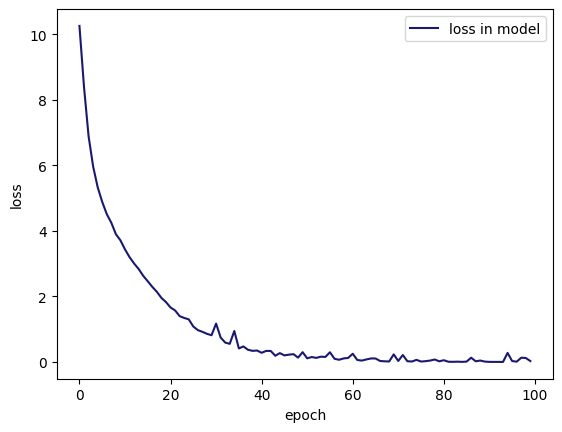

In [27]:
plt.plot(loss_list,label='loss in model',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

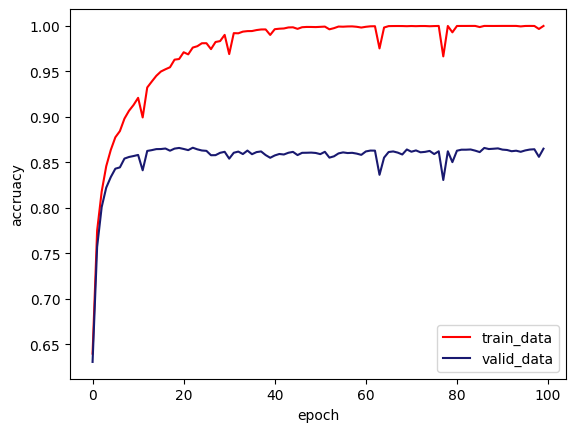

In [28]:
plt.plot(train_acc_list,label='train_data',color='red')
plt.plot(valid_acc_list,label='valid_data',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('accruacy')
plt.legend()
plt.show()

$\text{Weight initialization with normal mean 0 and std 1/len(data)}$

In [15]:
# Define the RNN model
class LSTM(nn.Module):
    def __init__(self, hidden_size, output_size,n_layers,embedding_dim):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers=n_layers
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_size,
                           num_layers=self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu=nn.ReLU()
        self.sigmoid=nn.Sigmoid()
        self.tanh=nn.Tanh()
        self.embed=nn.Embedding(len(vocab)+1,embedding_dim=embedding_dim)
    def forward(self, x):
       
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embed(x)
        # pass in the rnn layer
        output,hidden=self.lstm(embeds)
        
        
        output=output.contiguous().view(-1,self.hidden_size)
        
        output = self.sigmoid(self.fc(output))
        output=output.view(batch_size,-1)
        
        output=output[:,-1].view(batch_size,-1)
        
        return output

    def init_hidden(self,batch_size):
        hidden=torch.zeros(self.n_layers,batch_size,self.hidden_size).to(device)
        return hidden
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1.0/np.sqrt(37500))
            if module.bias is not None:
                module.bias.data.zero_()

In [30]:
hidden_size=100
output_size=1
n_layers=1
embedding_dim=64
model=LSTM(hidden_size,output_size,n_layers,embedding_dim).to(device)
criterion =nn.BCELoss()
lr=0.0001
train_acc_list=[]
valid_acc_list=[]
loss_list=[]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs=100
num_epochs=tqdm(range(epochs))

# n_epochs=tqdm(range(epochs))
for epoch in num_epochs:

    running_loss = 0

    for i,(instances, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        instances=instances.to(device)
        labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
        # print(instances.shape)
        output = model(instances)
        
        # print(labels.shape)
        # print(output.shape)
        # print(output)

        # print(output.shape)
        # print(labels.shape)
        loss = criterion(output, labels)


        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    loss_list.append(running_loss/batch_size)
    a=train_acc(model)
    train_acc_list.append(a)
    
    b=valid_acc(model)
    
    # print('accuracy over validation data set:',b)
    valid_acc_list.append(b)
    print('epoch is:',epoch+1,'accuracy over training/validation data set:',a,'/',b,' || running loss is:',running_loss/batch_size)
 


  1%|          | 1/100 [00:14<24:29, 14.85s/it]

epoch is: 1 accuracy over training/validation data set: 0.6769866666666666 / 0.66688  || running loss is: 10.071379940509797


  2%|▏         | 2/100 [00:29<24:07, 14.77s/it]

epoch is: 2 accuracy over training/validation data set: 0.77072 / 0.76176  || running loss is: 8.205381422638894


  3%|▎         | 3/100 [00:45<24:53, 15.40s/it]

epoch is: 3 accuracy over training/validation data set: 0.8209866666666666 / 0.80336  || running loss is: 6.813820114433765


  4%|▍         | 4/100 [01:02<25:30, 15.94s/it]

epoch is: 4 accuracy over training/validation data set: 0.8457333333333333 / 0.82816  || running loss is: 5.905552406013012


  5%|▌         | 5/100 [01:17<24:51, 15.70s/it]

epoch is: 5 accuracy over training/validation data set: 0.86248 / 0.83648  || running loss is: 5.31534327596426


  6%|▌         | 6/100 [01:32<24:17, 15.50s/it]

epoch is: 6 accuracy over training/validation data set: 0.8762133333333333 / 0.84368  || running loss is: 4.8609305129945275


  7%|▋         | 7/100 [01:47<23:35, 15.22s/it]

epoch is: 7 accuracy over training/validation data set: 0.88952 / 0.854  || running loss is: 4.521330955028534


  8%|▊         | 8/100 [02:02<23:03, 15.03s/it]

epoch is: 8 accuracy over training/validation data set: 0.89272 / 0.85232  || running loss is: 4.203954998403788


  9%|▉         | 9/100 [02:16<22:33, 14.87s/it]

epoch is: 9 accuracy over training/validation data set: 0.9058933333333333 / 0.85976  || running loss is: 3.9193984775245188


 10%|█         | 10/100 [02:31<22:06, 14.74s/it]

epoch is: 10 accuracy over training/validation data set: 0.9018933333333333 / 0.85408  || running loss is: 3.6434637801349163


 11%|█         | 11/100 [02:42<20:16, 13.67s/it]

epoch is: 11 accuracy over training/validation data set: 0.9222133333333333 / 0.86656  || running loss is: 3.4457792511582372


 12%|█▏        | 12/100 [02:57<20:32, 14.01s/it]

epoch is: 12 accuracy over training/validation data set: 0.9279733333333333 / 0.86872  || running loss is: 3.1956434240192175


 13%|█▎        | 13/100 [03:11<20:31, 14.16s/it]

epoch is: 13 accuracy over training/validation data set: 0.9333066666666666 / 0.86784  || running loss is: 2.98741340495646


 14%|█▍        | 14/100 [03:26<20:25, 14.25s/it]

epoch is: 14 accuracy over training/validation data set: 0.9398933333333334 / 0.86648  || running loss is: 2.806838346272707


 15%|█▌        | 15/100 [03:40<20:16, 14.31s/it]

epoch is: 15 accuracy over training/validation data set: 0.9468266666666667 / 0.86992  || running loss is: 2.6106470037996767


 16%|█▌        | 16/100 [03:55<20:06, 14.37s/it]

epoch is: 16 accuracy over training/validation data set: 0.94496 / 0.86464  || running loss is: 2.425103759020567


 17%|█▋        | 17/100 [04:09<20:02, 14.49s/it]

epoch is: 17 accuracy over training/validation data set: 0.9546933333333333 / 0.86936  || running loss is: 2.2584253404289485


 18%|█▊        | 18/100 [04:24<19:54, 14.57s/it]

epoch is: 18 accuracy over training/validation data set: 0.9565333333333333 / 0.8676  || running loss is: 2.078547106012702


 19%|█▉        | 19/100 [04:41<20:27, 15.16s/it]

epoch is: 19 accuracy over training/validation data set: 0.9607466666666666 / 0.87064  || running loss is: 1.9447725527733564


 20%|██        | 20/100 [04:56<20:12, 15.16s/it]

epoch is: 20 accuracy over training/validation data set: 0.9669866666666667 / 0.86688  || running loss is: 1.7989977735839784


 21%|██        | 21/100 [05:11<19:48, 15.04s/it]

epoch is: 21 accuracy over training/validation data set: 0.9705333333333334 / 0.8684  || running loss is: 1.678696395419538


 22%|██▏       | 22/100 [05:25<19:26, 14.95s/it]

epoch is: 22 accuracy over training/validation data set: 0.9741333333333333 / 0.86912  || running loss is: 1.5938883997499942


 23%|██▎       | 23/100 [05:40<19:02, 14.84s/it]

epoch is: 23 accuracy over training/validation data set: 0.9753066666666667 / 0.86792  || running loss is: 1.414240896552801


 24%|██▍       | 24/100 [05:55<18:44, 14.79s/it]

epoch is: 24 accuracy over training/validation data set: 0.9767466666666667 / 0.8672  || running loss is: 1.3060045421402902


 25%|██▌       | 25/100 [06:09<18:26, 14.76s/it]

epoch is: 25 accuracy over training/validation data set: 0.9497866666666667 / 0.84896  || running loss is: 1.262065442018211


 26%|██▌       | 26/100 [06:24<18:06, 14.68s/it]

epoch is: 26 accuracy over training/validation data set: 0.98352 / 0.86824  || running loss is: 1.152557139378041


 27%|██▋       | 27/100 [06:39<18:07, 14.90s/it]

epoch is: 27 accuracy over training/validation data set: 0.97944 / 0.86176  || running loss is: 1.059139568209648


 28%|██▊       | 28/100 [06:54<17:42, 14.76s/it]

epoch is: 28 accuracy over training/validation data set: 0.9864266666666667 / 0.86576  || running loss is: 0.913830112060532


 29%|██▉       | 29/100 [07:08<17:27, 14.75s/it]

epoch is: 29 accuracy over training/validation data set: 0.9795466666666667 / 0.86056  || running loss is: 0.9582209969032556


 30%|███       | 30/100 [07:25<17:47, 15.24s/it]

epoch is: 30 accuracy over training/validation data set: 0.9894933333333333 / 0.86408  || running loss is: 0.7540270211640745


 31%|███       | 31/100 [07:41<17:57, 15.62s/it]

epoch is: 31 accuracy over training/validation data set: 0.98952 / 0.86312  || running loss is: 0.7087832436384633


 32%|███▏      | 32/100 [07:58<18:06, 15.97s/it]

epoch is: 32 accuracy over training/validation data set: 0.98608 / 0.85664  || running loss is: 0.7604880273249001


 33%|███▎      | 33/100 [08:14<17:56, 16.06s/it]

epoch is: 33 accuracy over training/validation data set: 0.9905066666666666 / 0.86208  || running loss is: 0.558125457544811


 34%|███▍      | 34/100 [08:29<17:08, 15.58s/it]

epoch is: 34 accuracy over training/validation data set: 0.9931466666666666 / 0.862  || running loss is: 0.4927156093879603


 35%|███▌      | 35/100 [08:43<16:34, 15.30s/it]

epoch is: 35 accuracy over training/validation data set: 0.9926933333333333 / 0.862  || running loss is: 0.5545992711395956


 36%|███▌      | 36/100 [08:58<16:01, 15.03s/it]

epoch is: 36 accuracy over training/validation data set: 0.9950133333333333 / 0.86232  || running loss is: 0.404823340610601


 37%|███▋      | 37/100 [09:12<15:36, 14.86s/it]

epoch is: 37 accuracy over training/validation data set: 0.996 / 0.86128  || running loss is: 0.3733075416996144


 38%|███▊      | 38/100 [09:27<15:15, 14.77s/it]

epoch is: 38 accuracy over training/validation data set: 0.9960266666666666 / 0.86176  || running loss is: 0.3721924499853049


 39%|███▉      | 39/100 [09:41<14:53, 14.65s/it]

epoch is: 39 accuracy over training/validation data set: 0.99112 / 0.85736  || running loss is: 0.7914741537044756


 40%|████      | 40/100 [09:56<14:35, 14.59s/it]

epoch is: 40 accuracy over training/validation data set: 0.9971466666666666 / 0.86136  || running loss is: 0.31353362793801354


 41%|████      | 41/100 [10:10<14:20, 14.59s/it]

epoch is: 41 accuracy over training/validation data set: 0.99752 / 0.86136  || running loss is: 0.23889566313475372


 42%|████▏     | 42/100 [10:25<14:03, 14.55s/it]

epoch is: 42 accuracy over training/validation data set: 0.99816 / 0.86248  || running loss is: 0.20939854144002312


 43%|████▎     | 43/100 [10:39<13:46, 14.49s/it]

epoch is: 43 accuracy over training/validation data set: 0.9421866666666666 / 0.83336  || running loss is: 0.3191461370734032


 44%|████▍     | 44/100 [10:53<13:29, 14.45s/it]

epoch is: 44 accuracy over training/validation data set: 0.9970933333333334 / 0.86096  || running loss is: 0.3070705128274858


 45%|████▌     | 45/100 [11:08<13:15, 14.47s/it]

epoch is: 45 accuracy over training/validation data set: 0.9985866666666666 / 0.8604  || running loss is: 0.16304850143555086


 46%|████▌     | 46/100 [11:23<13:04, 14.53s/it]

epoch is: 46 accuracy over training/validation data set: 0.9990133333333333 / 0.86152  || running loss is: 0.13564875613781624


 47%|████▋     | 47/100 [11:37<12:50, 14.53s/it]

epoch is: 47 accuracy over training/validation data set: 0.98696 / 0.84824  || running loss is: 0.3120558993855957


 48%|████▊     | 48/100 [11:52<12:34, 14.50s/it]

epoch is: 48 accuracy over training/validation data set: 0.9853866666666666 / 0.84632  || running loss is: 0.19367751480138395


 49%|████▉     | 49/100 [12:06<12:16, 14.44s/it]

epoch is: 49 accuracy over training/validation data set: 0.99912 / 0.86184  || running loss is: 0.23450032265332993


 50%|█████     | 50/100 [12:20<12:04, 14.49s/it]

epoch is: 50 accuracy over training/validation data set: 0.9992266666666667 / 0.86256  || running loss is: 0.1342282478074776


 51%|█████     | 51/100 [12:35<11:49, 14.48s/it]

epoch is: 51 accuracy over training/validation data set: 0.9983733333333333 / 0.8624  || running loss is: 0.43810457785584733


 52%|█████▏    | 52/100 [12:49<11:35, 14.48s/it]

epoch is: 52 accuracy over training/validation data set: 0.9993866666666666 / 0.86208  || running loss is: 0.11911792282684473


 53%|█████▎    | 53/100 [13:01<10:34, 13.49s/it]

epoch is: 53 accuracy over training/validation data set: 0.9994933333333333 / 0.86112  || running loss is: 0.07585251146869268


 54%|█████▍    | 54/100 [13:12<09:48, 12.80s/it]

epoch is: 54 accuracy over training/validation data set: 0.9988266666666666 / 0.85824  || running loss is: 0.09056484517990611


 55%|█████▌    | 55/100 [13:26<09:59, 13.33s/it]

epoch is: 55 accuracy over training/validation data set: 0.9558133333333333 / 0.8288  || running loss is: 0.07640731496576336


 56%|█████▌    | 56/100 [13:43<10:26, 14.23s/it]

epoch is: 56 accuracy over training/validation data set: 0.9955733333333333 / 0.85912  || running loss is: 0.2642367410674342


 57%|█████▋    | 57/100 [13:57<10:14, 14.30s/it]

epoch is: 57 accuracy over training/validation data set: 0.9996533333333333 / 0.86224  || running loss is: 0.08535034643733524


 58%|█████▊    | 58/100 [14:12<10:03, 14.37s/it]

epoch is: 58 accuracy over training/validation data set: 0.9997066666666666 / 0.86408  || running loss is: 0.046828897398954725


 59%|█████▉    | 59/100 [14:26<09:50, 14.41s/it]

epoch is: 59 accuracy over training/validation data set: 0.9987733333333333 / 0.8588  || running loss is: 0.06336765847168863


 60%|██████    | 60/100 [14:41<09:38, 14.47s/it]

epoch is: 60 accuracy over training/validation data set: 0.9997333333333334 / 0.86376  || running loss is: 0.15118067560550116


 61%|██████    | 61/100 [14:55<09:23, 14.45s/it]

epoch is: 61 accuracy over training/validation data set: 0.9997866666666667 / 0.86288  || running loss is: 0.03514552210035617


 62%|██████▏   | 62/100 [15:10<09:10, 14.49s/it]

epoch is: 62 accuracy over training/validation data set: 0.9995733333333333 / 0.86192  || running loss is: 0.11062228564318502


 63%|██████▎   | 63/100 [15:24<08:56, 14.50s/it]

epoch is: 63 accuracy over training/validation data set: 0.99984 / 0.86144  || running loss is: 0.031550347094162136


 64%|██████▍   | 64/100 [15:39<08:41, 14.47s/it]

epoch is: 64 accuracy over training/validation data set: 0.99984 / 0.86264  || running loss is: 0.024060227062436754


 65%|██████▌   | 65/100 [15:53<08:25, 14.44s/it]

epoch is: 65 accuracy over training/validation data set: 0.9998666666666667 / 0.86032  || running loss is: 0.02183004987651657


 66%|██████▌   | 66/100 [16:08<08:18, 14.67s/it]

epoch is: 66 accuracy over training/validation data set: 0.9998933333333333 / 0.85808  || running loss is: 0.016385103522952704


 67%|██████▋   | 67/100 [16:23<08:06, 14.75s/it]

epoch is: 67 accuracy over training/validation data set: 0.99976 / 0.864  || running loss is: 0.23328623593828524


 68%|██████▊   | 68/100 [16:37<07:47, 14.61s/it]

epoch is: 68 accuracy over training/validation data set: 0.99992 / 0.86328  || running loss is: 0.0642714082798193


 69%|██████▉   | 69/100 [16:49<07:02, 13.62s/it]

epoch is: 69 accuracy over training/validation data set: 0.9999733333333334 / 0.86392  || running loss is: 0.016981946670348406


 70%|███████   | 70/100 [17:03<06:56, 13.88s/it]

epoch is: 70 accuracy over training/validation data set: 0.9999733333333334 / 0.86072  || running loss is: 0.010500191463961528


 71%|███████   | 71/100 [17:15<06:20, 13.13s/it]

epoch is: 71 accuracy over training/validation data set: 0.9999733333333334 / 0.86248  || running loss is: 0.009905199740642275


 72%|███████▏  | 72/100 [17:29<06:22, 13.65s/it]

epoch is: 72 accuracy over training/validation data set: 0.9999733333333334 / 0.86176  || running loss is: 0.007023563290258608


 73%|███████▎  | 73/100 [17:44<06:16, 13.94s/it]

epoch is: 73 accuracy over training/validation data set: 0.99936 / 0.86144  || running loss is: 0.6372400146789005


 74%|███████▍  | 74/100 [17:59<06:06, 14.11s/it]

epoch is: 74 accuracy over training/validation data set: 0.9999733333333334 / 0.86432  || running loss is: 0.026958855115080952


 75%|███████▌  | 75/100 [18:13<05:56, 14.27s/it]

epoch is: 75 accuracy over training/validation data set: 0.9999733333333334 / 0.8624  || running loss is: 0.012969159564454458


 76%|███████▌  | 76/100 [18:28<05:43, 14.30s/it]

epoch is: 76 accuracy over training/validation data set: 0.9999733333333334 / 0.86192  || running loss is: 0.009914298763105763


 77%|███████▋  | 77/100 [18:43<05:38, 14.70s/it]

epoch is: 77 accuracy over training/validation data set: 0.9999733333333334 / 0.86272  || running loss is: 0.008462879757207702


 78%|███████▊  | 78/100 [18:58<05:25, 14.77s/it]

epoch is: 78 accuracy over training/validation data set: 0.9999733333333334 / 0.86248  || running loss is: 0.0072045566927045005


 79%|███████▉  | 79/100 [19:13<05:08, 14.68s/it]

epoch is: 79 accuracy over training/validation data set: 0.9930933333333334 / 0.85336  || running loss is: 0.17709473572384013


 80%|████████  | 80/100 [19:28<04:54, 14.74s/it]

epoch is: 80 accuracy over training/validation data set: 0.99992 / 0.86288  || running loss is: 0.1630058203896624


 81%|████████  | 81/100 [19:42<04:41, 14.79s/it]

epoch is: 81 accuracy over training/validation data set: 0.99992 / 0.86536  || running loss is: 0.022043391213737776


 82%|████████▏ | 82/100 [19:55<04:11, 14.00s/it]

epoch is: 82 accuracy over training/validation data set: 0.99976 / 0.86352  || running loss is: 0.037723669480110404


 83%|████████▎ | 83/100 [20:09<04:01, 14.22s/it]

epoch is: 83 accuracy over training/validation data set: 0.9994933333333333 / 0.86376  || running loss is: 0.041328648977687406


 84%|████████▍ | 84/100 [20:24<03:50, 14.38s/it]

epoch is: 84 accuracy over training/validation data set: 0.9993866666666666 / 0.8644  || running loss is: 0.059829025333674506


 85%|████████▌ | 85/100 [20:39<03:36, 14.45s/it]

epoch is: 85 accuracy over training/validation data set: 0.9999733333333334 / 0.86528  || running loss is: 0.014930878605482575


 86%|████████▌ | 86/100 [20:53<03:22, 14.45s/it]

epoch is: 86 accuracy over training/validation data set: 0.9999733333333334 / 0.86536  || running loss is: 0.006083092824555933


 87%|████████▋ | 87/100 [21:08<03:08, 14.51s/it]

epoch is: 87 accuracy over training/validation data set: 0.9999466666666667 / 0.86472  || running loss is: 0.004891685143247742


 88%|████████▊ | 88/100 [21:22<02:54, 14.54s/it]

epoch is: 88 accuracy over training/validation data set: 0.9999733333333334 / 0.8652  || running loss is: 0.004347110308663105


 89%|████████▉ | 89/100 [21:38<02:42, 14.77s/it]

epoch is: 89 accuracy over training/validation data set: 0.9999466666666667 / 0.86448  || running loss is: 0.00345922806447561


 90%|█████████ | 90/100 [21:52<02:26, 14.67s/it]

epoch is: 90 accuracy over training/validation data set: 0.99984 / 0.86368  || running loss is: 0.20462228004098507


 91%|█████████ | 91/100 [22:07<02:11, 14.61s/it]

epoch is: 91 accuracy over training/validation data set: 0.9999733333333334 / 0.8636  || running loss is: 0.015443670378372189


 92%|█████████▏| 92/100 [22:21<01:56, 14.61s/it]

epoch is: 92 accuracy over training/validation data set: 0.9999733333333334 / 0.86448  || running loss is: 0.004498160866132821


 93%|█████████▎| 93/100 [22:36<01:41, 14.56s/it]

epoch is: 93 accuracy over training/validation data set: 0.9999733333333334 / 0.86288  || running loss is: 0.0034294866171330797


 94%|█████████▍| 94/100 [22:50<01:27, 14.58s/it]

epoch is: 94 accuracy over training/validation data set: 1.0 / 0.86352  || running loss is: 0.002600590161200671


 95%|█████████▌| 95/100 [23:05<01:12, 14.55s/it]

epoch is: 95 accuracy over training/validation data set: 1.0 / 0.8632  || running loss is: 0.002033078825297707


 96%|█████████▌| 96/100 [23:19<00:58, 14.58s/it]

epoch is: 96 accuracy over training/validation data set: 0.9828266666666666 / 0.8428  || running loss is: 0.046229103061741626


 97%|█████████▋| 97/100 [23:34<00:43, 14.58s/it]

epoch is: 97 accuracy over training/validation data set: 0.99992 / 0.86568  || running loss is: 0.10840666896650873


 98%|█████████▊| 98/100 [23:48<00:29, 14.55s/it]

epoch is: 98 accuracy over training/validation data set: 0.9991466666666666 / 0.86432  || running loss is: 0.05119090412299556


 99%|█████████▉| 99/100 [24:03<00:14, 14.57s/it]

epoch is: 99 accuracy over training/validation data set: 0.9999733333333334 / 0.86376  || running loss is: 0.017535499635341692


100%|██████████| 100/100 [24:18<00:00, 14.58s/it]

epoch is: 100 accuracy over training/validation data set: 0.9982933333333334 / 0.85648  || running loss is: 0.046550336135460384


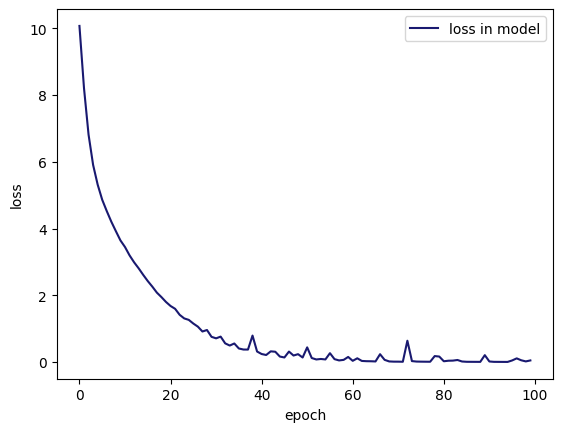

In [31]:
plt.plot(loss_list,label='loss in model',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

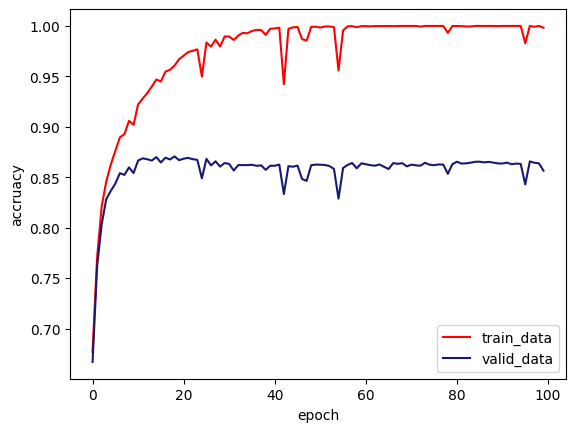

In [32]:
plt.plot(train_acc_list,label='train_data',color='red')
plt.plot(valid_acc_list,label='valid_data',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('accruacy')
plt.legend()
plt.show()

$\large \text{We obsereved that weight initilization does not work properly for overfitting.}$

$\huge \text{L2 Regularization:}$

In [17]:
hidden_size=100
output_size=1
n_layers=1
embedding_dim=64
lembda=0.01
model=LSTM(hidden_size,output_size,n_layers,embedding_dim).to(device)
criterion =nn.BCELoss()
lr=0.0001
train_acc_list=[]
valid_acc_list=[]
loss_list=[]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs=50
num_epochs=tqdm(range(epochs))

# n_epochs=tqdm(range(epochs))
for epoch in num_epochs:

    running_loss = 0

    for i,(instances, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        instances=instances.to(device)
        labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
        # print(instances.shape)
        output = model(instances)
        # manually regularization
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())/50

        #print(output)
        loss = criterion(output, labels)+lembda*l2_norm
        


        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_list.append(running_loss/batch_size)
    a=train_acc(model)
    train_acc_list.append(a)
    
    b=valid_acc(model)
    
    # print('accuracy over validation data set:',b)
    valid_acc_list.append(b)
    print('epoch is:',epoch+1,'accuracy over training/validation data set:',a,'/',b,' || running loss is:',running_loss/batch_size)
 


  2%|▏         | 1/50 [00:16<13:49, 16.93s/it]

epoch is: 1 accuracy over training/validation data set: 0.5722933333333333 / 0.56424  || running loss is: 27092.73781738281


  4%|▍         | 2/50 [00:33<13:25, 16.78s/it]

epoch is: 2 accuracy over training/validation data set: 0.69848 / 0.6916  || running loss is: 24061.317028808593


  6%|▌         | 3/50 [00:45<11:25, 14.59s/it]

epoch is: 3 accuracy over training/validation data set: 0.7889866666666666 / 0.77496  || running loss is: 21367.144438476564


  8%|▊         | 4/50 [01:01<11:35, 15.13s/it]

epoch is: 4 accuracy over training/validation data set: 0.81496 / 0.80048  || running loss is: 18955.200029296873


 10%|█         | 5/50 [01:17<11:31, 15.38s/it]

epoch is: 5 accuracy over training/validation data set: 0.8201333333333334 / 0.80776  || running loss is: 16786.67711669922


 12%|█▏        | 6/50 [01:33<11:27, 15.62s/it]

epoch is: 6 accuracy over training/validation data set: 0.8197066666666667 / 0.80568  || running loss is: 14833.02972290039


 14%|█▍        | 7/50 [01:49<11:21, 15.84s/it]

epoch is: 7 accuracy over training/validation data set: 0.8370933333333334 / 0.82008  || running loss is: 13072.940307617188


 16%|█▌        | 8/50 [02:05<11:03, 15.79s/it]

epoch is: 8 accuracy over training/validation data set: 0.84816 / 0.832  || running loss is: 11489.244409179688


 18%|█▊        | 9/50 [02:20<10:43, 15.70s/it]

epoch is: 9 accuracy over training/validation data set: 0.85592 / 0.8348  || running loss is: 10067.470767822266


 20%|██        | 10/50 [02:36<10:28, 15.71s/it]

epoch is: 10 accuracy over training/validation data set: 0.8644533333333333 / 0.83992  || running loss is: 8794.563627929687


 22%|██▏       | 11/50 [02:52<10:12, 15.71s/it]

epoch is: 11 accuracy over training/validation data set: 0.8496533333333334 / 0.83536  || running loss is: 7658.32358215332


 24%|██▍       | 12/50 [03:08<10:00, 15.81s/it]

epoch is: 12 accuracy over training/validation data set: 0.87136 / 0.84872  || running loss is: 6647.571890258789


 26%|██▌       | 13/50 [03:24<09:47, 15.88s/it]

epoch is: 13 accuracy over training/validation data set: 0.8677866666666667 / 0.84624  || running loss is: 5751.443782348633


 28%|██▊       | 14/50 [03:40<09:32, 15.90s/it]

epoch is: 14 accuracy over training/validation data set: 0.8705333333333334 / 0.8436  || running loss is: 4959.778908691406


 30%|███       | 15/50 [03:56<09:17, 15.92s/it]

epoch is: 15 accuracy over training/validation data set: 0.8785866666666666 / 0.85336  || running loss is: 4262.877053833008


 32%|███▏      | 16/50 [04:12<09:00, 15.90s/it]

epoch is: 16 accuracy over training/validation data set: 0.87568 / 0.85216  || running loss is: 3651.742483520508


 34%|███▍      | 17/50 [04:28<08:48, 16.03s/it]

epoch is: 17 accuracy over training/validation data set: 0.882 / 0.85368  || running loss is: 3117.5344287109374


 36%|███▌      | 18/50 [04:40<07:54, 14.83s/it]

epoch is: 18 accuracy over training/validation data set: 0.8919466666666667 / 0.86192  || running loss is: 2652.529989013672


 38%|███▊      | 19/50 [04:57<07:55, 15.33s/it]

epoch is: 19 accuracy over training/validation data set: 0.8704266666666667 / 0.84672  || running loss is: 2249.3787322998046


 40%|████      | 20/50 [05:15<08:05, 16.20s/it]

epoch is: 20 accuracy over training/validation data set: 0.8661866666666667 / 0.8452  || running loss is: 1900.9659178161621


 42%|████▏     | 21/50 [05:31<07:49, 16.20s/it]

epoch is: 21 accuracy over training/validation data set: 0.88584 / 0.85872  || running loss is: 1601.153081512451


 44%|████▍     | 22/50 [05:47<07:33, 16.19s/it]

epoch is: 22 accuracy over training/validation data set: 0.8869866666666667 / 0.85552  || running loss is: 1344.2834272766113


 46%|████▌     | 23/50 [06:03<07:16, 16.17s/it]

epoch is: 23 accuracy over training/validation data set: 0.8948266666666667 / 0.86392  || running loss is: 1124.8546516418457


 48%|████▊     | 24/50 [06:20<07:02, 16.25s/it]

epoch is: 24 accuracy over training/validation data set: 0.90824 / 0.87  || running loss is: 938.4096489715577


 50%|█████     | 25/50 [06:36<06:46, 16.25s/it]

epoch is: 25 accuracy over training/validation data set: 0.91 / 0.87288  || running loss is: 780.4699005889893


 52%|█████▏    | 26/50 [06:52<06:27, 16.15s/it]

epoch is: 26 accuracy over training/validation data set: 0.9210933333333333 / 0.87704  || running loss is: 647.2807515716553


 54%|█████▍    | 27/50 [07:08<06:11, 16.13s/it]

epoch is: 27 accuracy over training/validation data set: 0.92616 / 0.876  || running loss is: 535.4735252380372


 56%|█████▌    | 28/50 [07:24<05:54, 16.12s/it]

epoch is: 28 accuracy over training/validation data set: 0.9347466666666666 / 0.87592  || running loss is: 442.02230659484866


 58%|█████▊    | 29/50 [07:40<05:37, 16.06s/it]

epoch is: 29 accuracy over training/validation data set: 0.9308 / 0.86688  || running loss is: 364.1771839141846


 60%|██████    | 30/50 [07:56<05:21, 16.07s/it]

epoch is: 30 accuracy over training/validation data set: 0.9500533333333333 / 0.87896  || running loss is: 299.53431964874267


 62%|██████▏   | 31/50 [08:12<05:04, 16.03s/it]

epoch is: 31 accuracy over training/validation data set: 0.9516266666666666 / 0.88096  || running loss is: 246.1414845275879


 64%|██████▍   | 32/50 [08:28<04:47, 15.99s/it]

epoch is: 32 accuracy over training/validation data set: 0.9632533333333333 / 0.88432  || running loss is: 202.1562413406372


 66%|██████▌   | 33/50 [08:44<04:31, 15.97s/it]

epoch is: 33 accuracy over training/validation data set: 0.9637866666666667 / 0.87736  || running loss is: 165.87566053390503


 68%|██████▊   | 34/50 [09:00<04:15, 15.97s/it]

epoch is: 34 accuracy over training/validation data set: 0.9637866666666667 / 0.87944  || running loss is: 136.16923290252686


 70%|███████   | 35/50 [09:16<03:59, 15.97s/it]

epoch is: 35 accuracy over training/validation data set: 0.9759466666666666 / 0.88008  || running loss is: 112.23815625190736


 72%|███████▏  | 36/50 [09:31<03:41, 15.83s/it]

epoch is: 36 accuracy over training/validation data set: 0.9666133333333333 / 0.87384  || running loss is: 92.15938953399659


 74%|███████▍  | 37/50 [09:47<03:26, 15.91s/it]

epoch is: 37 accuracy over training/validation data set: 0.98392 / 0.87824  || running loss is: 76.13256727218628


 76%|███████▌  | 38/50 [10:03<03:10, 15.88s/it]

epoch is: 38 accuracy over training/validation data set: 0.98672 / 0.8804  || running loss is: 63.08942694664002


 78%|███████▊  | 39/50 [10:19<02:55, 15.95s/it]

epoch is: 39 accuracy over training/validation data set: 0.9854933333333333 / 0.87536  || running loss is: 52.54398188114166


 80%|████████  | 40/50 [10:35<02:39, 15.94s/it]

epoch is: 40 accuracy over training/validation data set: 0.9822933333333334 / 0.87248  || running loss is: 44.06379671573639


 82%|████████▏ | 41/50 [10:51<02:23, 15.91s/it]

epoch is: 41 accuracy over training/validation data set: 0.99128 / 0.87584  || running loss is: 37.2541969203949


 84%|████████▍ | 42/50 [11:07<02:06, 15.85s/it]

epoch is: 42 accuracy over training/validation data set: 0.9905333333333334 / 0.8756  || running loss is: 31.755814151763914


 86%|████████▌ | 43/50 [11:23<01:50, 15.84s/it]

epoch is: 43 accuracy over training/validation data set: 0.9914666666666667 / 0.87208  || running loss is: 27.481787464618684


 88%|████████▊ | 44/50 [11:38<01:34, 15.82s/it]

epoch is: 44 accuracy over training/validation data set: 0.99456 / 0.87424  || running loss is: 23.87881291627884


 90%|█████████ | 45/50 [11:54<01:19, 15.88s/it]

epoch is: 45 accuracy over training/validation data set: 0.9939466666666666 / 0.87272  || running loss is: 21.05450999259949


 92%|█████████▏| 46/50 [12:10<01:03, 15.87s/it]

epoch is: 46 accuracy over training/validation data set: 0.9940533333333333 / 0.87384  || running loss is: 18.872546532154082


 94%|█████████▍| 47/50 [12:26<00:47, 15.83s/it]

epoch is: 47 accuracy over training/validation data set: 0.9959466666666666 / 0.8716  || running loss is: 17.040253069400787


 96%|█████████▌| 48/50 [12:42<00:31, 15.84s/it]

epoch is: 48 accuracy over training/validation data set: 0.9898933333333333 / 0.87032  || running loss is: 15.567880092859268


 98%|█████████▊| 49/50 [12:58<00:15, 15.87s/it]

epoch is: 49 accuracy over training/validation data set: 0.9947733333333333 / 0.87048  || running loss is: 14.344994049072266


100%|██████████| 50/50 [13:14<00:00, 15.88s/it]

epoch is: 50 accuracy over training/validation data set: 0.98504 / 0.86184  || running loss is: 13.496543256044388


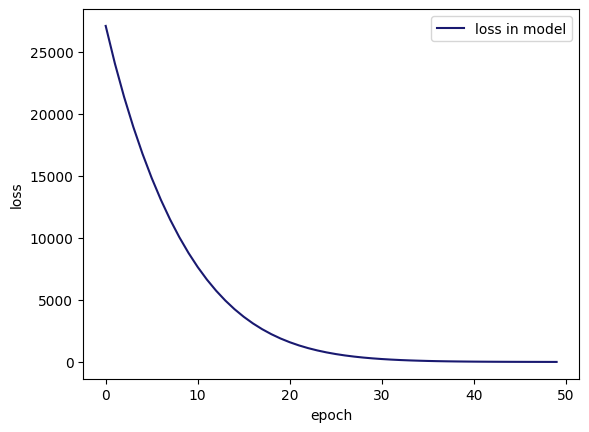

In [18]:
plt.plot(loss_list,label='loss in model',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

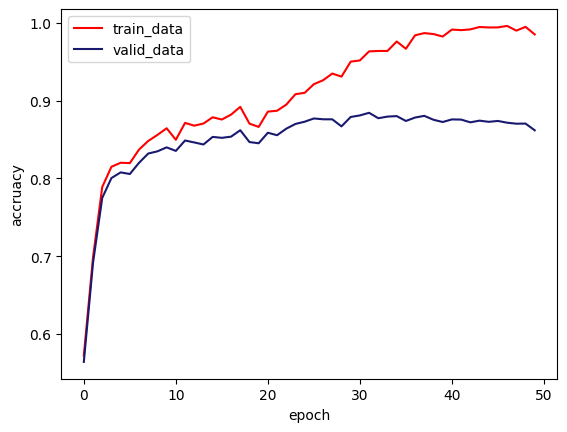

In [19]:
plt.plot(train_acc_list,label='train_data',color='red')
plt.plot(valid_acc_list,label='valid_data',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('accruacy')
plt.legend()
plt.show()

$\huge \text{L1 Regularization:}$

In [20]:
hidden_size=100
output_size=1
n_layers=1
embedding_dim=64
lembda=0.01
model=LSTM(hidden_size,output_size,n_layers,embedding_dim).to(device)
criterion =nn.BCELoss()
lr=0.0001
train_acc_list=[]
valid_acc_list=[]
loss_list=[]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs=50
num_epochs=tqdm(range(epochs))

# n_epochs=tqdm(range(epochs))
for epoch in num_epochs:

    running_loss = 0

    for i,(instances, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        instances=instances.to(device)
        labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
        # print(instances.shape)
        output = model(instances)
        # manually regularization
        l1_norm = sum(p.abs().sum() for p in model.parameters())/50
        #print(output)
        loss = criterion(output, labels)+lembda*l1_norm
        


        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_list.append(running_loss/batch_size)
    a=train_acc(model)
    train_acc_list.append(a)
    
    b=valid_acc(model)
    
    # print('accuracy over validation data set:',b)
    valid_acc_list.append(b)
    print('epoch is:',epoch+1,'accuracy over training/validation data set:',a,'/',b,' || running loss is:',running_loss/batch_size)
 


  2%|▏         | 1/50 [00:15<12:54, 15.81s/it]

epoch is: 1 accuracy over training/validation data set: 0.55384 / 0.55512  || running loss is: 21900.526967773436


  4%|▍         | 2/50 [00:31<12:43, 15.91s/it]

epoch is: 2 accuracy over training/validation data set: 0.5548 / 0.55592  || running loss is: 19868.283312988282


  6%|▌         | 3/50 [00:47<12:26, 15.89s/it]

epoch is: 3 accuracy over training/validation data set: 0.5537066666666667 / 0.55288  || running loss is: 17968.402453613282


  8%|▊         | 4/50 [01:05<12:53, 16.83s/it]

epoch is: 4 accuracy over training/validation data set: 0.55448 / 0.5544  || running loss is: 16195.772575683593


 10%|█         | 5/50 [01:22<12:30, 16.67s/it]

epoch is: 5 accuracy over training/validation data set: 0.55472 / 0.55544  || running loss is: 14548.062344970704


 12%|█▏        | 6/50 [01:38<12:02, 16.42s/it]

epoch is: 6 accuracy over training/validation data set: 0.5555733333333334 / 0.55672  || running loss is: 13022.19830444336


 14%|█▍        | 7/50 [01:54<11:38, 16.26s/it]

epoch is: 7 accuracy over training/validation data set: 0.5564266666666666 / 0.56048  || running loss is: 11614.605985107422


 16%|█▌        | 8/50 [02:07<10:43, 15.32s/it]

epoch is: 8 accuracy over training/validation data set: 0.55904 / 0.55904  || running loss is: 10321.327880859375


 18%|█▊        | 9/50 [02:23<10:34, 15.48s/it]

epoch is: 9 accuracy over training/validation data set: 0.5634933333333333 / 0.56176  || running loss is: 9138.04265625


 20%|██        | 10/50 [02:38<10:21, 15.53s/it]

epoch is: 10 accuracy over training/validation data set: 0.5698933333333334 / 0.56584  || running loss is: 8059.908033447266


 22%|██▏       | 11/50 [02:54<10:06, 15.55s/it]

epoch is: 11 accuracy over training/validation data set: 0.61224 / 0.61456  || running loss is: 7081.962269897461


 24%|██▍       | 12/50 [03:10<09:52, 15.60s/it]

epoch is: 12 accuracy over training/validation data set: 0.68384 / 0.67608  || running loss is: 6198.785101928711


 26%|██▌       | 13/50 [03:25<09:37, 15.60s/it]

epoch is: 13 accuracy over training/validation data set: 0.7101066666666667 / 0.70416  || running loss is: 5407.354505615234


 28%|██▊       | 14/50 [03:41<09:23, 15.64s/it]

epoch is: 14 accuracy over training/validation data set: 0.7215733333333333 / 0.71728  || running loss is: 4702.019631347656


 30%|███       | 15/50 [03:57<09:06, 15.61s/it]

epoch is: 15 accuracy over training/validation data set: 0.7408 / 0.73344  || running loss is: 4075.274655456543


 32%|███▏      | 16/50 [04:12<08:50, 15.62s/it]

epoch is: 16 accuracy over training/validation data set: 0.7509866666666667 / 0.74424  || running loss is: 3520.021341552734


 34%|███▍      | 17/50 [04:28<08:40, 15.76s/it]

epoch is: 17 accuracy over training/validation data set: 0.7634666666666666 / 0.75184  || running loss is: 3029.8548696899416


 36%|███▌      | 18/50 [04:44<08:23, 15.73s/it]

epoch is: 18 accuracy over training/validation data set: 0.7729866666666667 / 0.76168  || running loss is: 2598.744811706543


 38%|███▊      | 19/50 [05:00<08:06, 15.68s/it]

epoch is: 19 accuracy over training/validation data set: 0.7824266666666667 / 0.7692  || running loss is: 2221.188878479004


 40%|████      | 20/50 [05:16<07:56, 15.88s/it]

epoch is: 20 accuracy over training/validation data set: 0.7882933333333333 / 0.77776  || running loss is: 1892.003895263672


 42%|████▏     | 21/50 [05:33<07:47, 16.12s/it]

epoch is: 21 accuracy over training/validation data set: 0.7955466666666666 / 0.78464  || running loss is: 1606.1652182006835


 44%|████▍     | 22/50 [05:48<07:26, 15.95s/it]

epoch is: 22 accuracy over training/validation data set: 0.80192 / 0.79  || running loss is: 1359.1660238647462


 46%|████▌     | 23/50 [06:04<07:07, 15.82s/it]

epoch is: 23 accuracy over training/validation data set: 0.8076 / 0.79408  || running loss is: 1146.4420246887207


 48%|████▊     | 24/50 [06:19<06:49, 15.75s/it]

epoch is: 24 accuracy over training/validation data set: 0.8132 / 0.80072  || running loss is: 963.9975401306152


 50%|█████     | 25/50 [06:35<06:32, 15.68s/it]

epoch is: 25 accuracy over training/validation data set: 0.81768 / 0.80456  || running loss is: 808.1880061340332


 52%|█████▏    | 26/50 [06:50<06:16, 15.68s/it]

epoch is: 26 accuracy over training/validation data set: 0.8149866666666666 / 0.8052  || running loss is: 675.7677948760986


 54%|█████▍    | 27/50 [07:06<05:59, 15.63s/it]

epoch is: 27 accuracy over training/validation data set: 0.8251466666666667 / 0.8132  || running loss is: 563.7180424499512


 56%|█████▌    | 28/50 [07:22<05:43, 15.61s/it]

epoch is: 28 accuracy over training/validation data set: 0.83016 / 0.81704  || running loss is: 469.25185623168943


 58%|█████▊    | 29/50 [07:37<05:28, 15.63s/it]

epoch is: 29 accuracy over training/validation data set: 0.8303733333333333 / 0.81912  || running loss is: 389.9439574813843


 60%|██████    | 30/50 [07:53<05:13, 15.67s/it]

epoch is: 30 accuracy over training/validation data set: 0.8349066666666667 / 0.82168  || running loss is: 323.57079570770264


 62%|██████▏   | 31/50 [08:09<04:57, 15.65s/it]

epoch is: 31 accuracy over training/validation data set: 0.83752 / 0.8264  || running loss is: 268.1619120025635


 64%|██████▍   | 32/50 [08:24<04:43, 15.73s/it]

epoch is: 32 accuracy over training/validation data set: 0.83792 / 0.82784  || running loss is: 222.18215147018432


 66%|██████▌   | 33/50 [08:40<04:26, 15.70s/it]

epoch is: 33 accuracy over training/validation data set: 0.84392 / 0.83088  || running loss is: 184.21018297195434


 68%|██████▊   | 34/50 [08:56<04:10, 15.68s/it]

epoch is: 34 accuracy over training/validation data set: 0.84528 / 0.83208  || running loss is: 152.9804811668396


 70%|███████   | 35/50 [09:11<03:54, 15.66s/it]

epoch is: 35 accuracy over training/validation data set: 0.8444266666666667 / 0.83504  || running loss is: 127.35626372337342


 72%|███████▏  | 36/50 [09:27<03:39, 15.68s/it]

epoch is: 36 accuracy over training/validation data set: 0.8491733333333333 / 0.83896  || running loss is: 106.44747049331664


 74%|███████▍  | 37/50 [09:43<03:23, 15.66s/it]

epoch is: 37 accuracy over training/validation data set: 0.84904 / 0.83608  || running loss is: 89.4076274394989


 76%|███████▌  | 38/50 [09:59<03:08, 15.71s/it]

epoch is: 38 accuracy over training/validation data set: 0.8456533333333334 / 0.83328  || running loss is: 75.56014401435851


 78%|███████▊  | 39/50 [10:14<02:52, 15.72s/it]

epoch is: 39 accuracy over training/validation data set: 0.8537333333333333 / 0.84192  || running loss is: 64.30750651836395


 80%|████████  | 40/50 [10:30<02:37, 15.77s/it]

epoch is: 40 accuracy over training/validation data set: 0.8546133333333333 / 0.84152  || running loss is: 55.214972376823425


 82%|████████▏ | 41/50 [10:46<02:22, 15.87s/it]

epoch is: 41 accuracy over training/validation data set: 0.8554133333333334 / 0.84584  || running loss is: 47.85685158252716


 84%|████████▍ | 42/50 [11:02<02:05, 15.69s/it]

epoch is: 42 accuracy over training/validation data set: 0.85608 / 0.84848  || running loss is: 41.916163854599


 86%|████████▌ | 43/50 [11:17<01:49, 15.61s/it]

epoch is: 43 accuracy over training/validation data set: 0.85616 / 0.84328  || running loss is: 37.11973442077637


 88%|████████▊ | 44/50 [11:33<01:33, 15.62s/it]

epoch is: 44 accuracy over training/validation data set: 0.8604 / 0.8488  || running loss is: 33.23469180583954


 90%|█████████ | 45/50 [11:48<01:18, 15.67s/it]

epoch is: 45 accuracy over training/validation data set: 0.85896 / 0.84688  || running loss is: 30.07519241809845


 92%|█████████▏| 46/50 [12:04<01:02, 15.66s/it]

epoch is: 46 accuracy over training/validation data set: 0.8602666666666666 / 0.84848  || running loss is: 27.49226795196533


 94%|█████████▍| 47/50 [12:20<00:46, 15.65s/it]

epoch is: 47 accuracy over training/validation data set: 0.8626666666666667 / 0.85168  || running loss is: 25.379111378192903


 96%|█████████▌| 48/50 [12:35<00:31, 15.63s/it]

epoch is: 48 accuracy over training/validation data set: 0.8613866666666666 / 0.84784  || running loss is: 23.646139633655547


 98%|█████████▊| 49/50 [12:51<00:15, 15.60s/it]

epoch is: 49 accuracy over training/validation data set: 0.8610133333333333 / 0.84928  || running loss is: 22.226522793769835


100%|██████████| 50/50 [13:06<00:00, 15.74s/it]

epoch is: 50 accuracy over training/validation data set: 0.8646666666666667 / 0.85392  || running loss is: 21.033026072978974


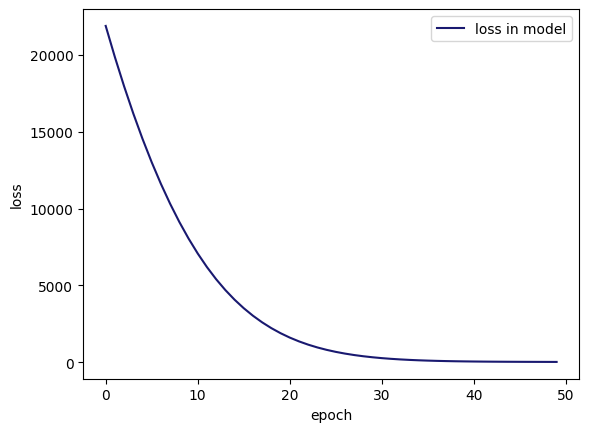

In [21]:
plt.plot(loss_list,label='loss in model',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

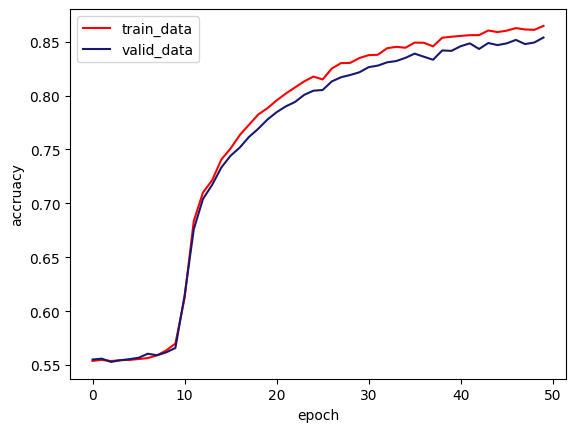

In [22]:
plt.plot(train_acc_list,label='train_data',color='red')
plt.plot(valid_acc_list,label='valid_data',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('accruacy')
plt.legend()
plt.show()

$\large \text{Weight Decay:}$

In [23]:
hidden_size=100
output_size=1
n_layers=1
embedding_dim=64
lembda=0.01
model=LSTM(hidden_size,output_size,n_layers,embedding_dim).to(device)
criterion =nn.BCELoss()
lr=0.0001
train_acc_list=[]
valid_acc_list=[]
loss_list=[]
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=lembda)
epochs=100
num_epochs=tqdm(range(epochs))

# n_epochs=tqdm(range(epochs))
for epoch in num_epochs:

    running_loss = 0

    for i,(instances, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        instances=instances.to(device)
        labels=labels.reshape(len(labels),-1).to(device).to(torch.float32)
        # print(instances.shape)
        output = model(instances)
        #print(output)
        loss = criterion(output, labels)
        


        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_list.append(running_loss/batch_size)
    a=train_acc(model)
    train_acc_list.append(a)
    
    b=valid_acc(model)
    
    # print('accuracy over validation data set:',b)
    valid_acc_list.append(b)
    print('epoch is:',epoch+1,'accuracy over training/validation data set:',a,'/',b,' || running loss is:',running_loss/batch_size)
 


  1%|          | 1/100 [00:14<24:41, 14.96s/it]

epoch is: 1 accuracy over training/validation data set: 0.54184 / 0.538  || running loss is: 10.374521315097809


  2%|▏         | 2/100 [00:29<24:24, 14.94s/it]

epoch is: 2 accuracy over training/validation data set: 0.5505333333333333 / 0.5456  || running loss is: 10.344669674634934


  3%|▎         | 3/100 [00:44<24:13, 14.98s/it]

epoch is: 3 accuracy over training/validation data set: 0.5524 / 0.55176  || running loss is: 10.332707215547561


  4%|▍         | 4/100 [01:00<24:16, 15.17s/it]

epoch is: 4 accuracy over training/validation data set: 0.5545066666666667 / 0.54952  || running loss is: 10.327291423082352


  5%|▌         | 5/100 [01:15<24:06, 15.23s/it]

epoch is: 5 accuracy over training/validation data set: 0.5560266666666667 / 0.5528  || running loss is: 10.32331111907959


  6%|▌         | 6/100 [01:30<23:45, 15.17s/it]

epoch is: 6 accuracy over training/validation data set: 0.55824 / 0.55616  || running loss is: 10.320961349010467


  7%|▋         | 7/100 [01:42<22:01, 14.20s/it]

epoch is: 7 accuracy over training/validation data set: 0.5582933333333333 / 0.5576  || running loss is: 10.318999906778336


  8%|▊         | 8/100 [01:57<22:04, 14.40s/it]

epoch is: 8 accuracy over training/validation data set: 0.5583466666666667 / 0.55352  || running loss is: 10.324533914327622


  9%|▉         | 9/100 [02:12<22:09, 14.60s/it]

epoch is: 9 accuracy over training/validation data set: 0.5594133333333333 / 0.5556  || running loss is: 10.325245472192764


 10%|█         | 10/100 [02:27<22:00, 14.67s/it]

epoch is: 10 accuracy over training/validation data set: 0.5588 / 0.5548  || running loss is: 10.33723226070404


 11%|█         | 11/100 [02:42<21:57, 14.81s/it]

epoch is: 11 accuracy over training/validation data set: 0.5604533333333334 / 0.55592  || running loss is: 10.344354566335678


 12%|█▏        | 12/100 [02:57<21:52, 14.92s/it]

epoch is: 12 accuracy over training/validation data set: 0.5585866666666667 / 0.554  || running loss is: 10.353270664215088


 13%|█▎        | 13/100 [03:12<21:33, 14.87s/it]

epoch is: 13 accuracy over training/validation data set: 0.5580266666666667 / 0.55392  || running loss is: 10.365950878858566


 14%|█▍        | 14/100 [03:27<21:13, 14.81s/it]

epoch is: 14 accuracy over training/validation data set: 0.55608 / 0.55384  || running loss is: 10.376788623332978


 15%|█▌        | 15/100 [03:42<21:02, 14.85s/it]

epoch is: 15 accuracy over training/validation data set: 0.5492 / 0.5452  || running loss is: 10.38506651878357


 16%|█▌        | 16/100 [03:57<20:51, 14.89s/it]

epoch is: 16 accuracy over training/validation data set: 0.53616 / 0.53584  || running loss is: 10.391485973596573


 17%|█▋        | 17/100 [04:12<20:44, 14.99s/it]

epoch is: 17 accuracy over training/validation data set: 0.5024533333333333 / 0.5012  || running loss is: 10.395154000520707


 18%|█▊        | 18/100 [04:28<20:43, 15.17s/it]

epoch is: 18 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.396762744188308


 19%|█▉        | 19/100 [04:44<20:47, 15.41s/it]

epoch is: 19 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397168658971786


 20%|██        | 20/100 [05:00<20:45, 15.56s/it]

epoch is: 20 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397273043394089


 21%|██        | 21/100 [05:15<20:20, 15.45s/it]

epoch is: 21 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397261431217194


 22%|██▏       | 22/100 [05:30<20:00, 15.40s/it]

epoch is: 22 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.39726520061493


 23%|██▎       | 23/100 [05:46<20:10, 15.72s/it]

epoch is: 23 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397259645462036


 24%|██▍       | 24/100 [06:02<19:50, 15.66s/it]

epoch is: 24 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397248404026032


 25%|██▌       | 25/100 [06:17<19:29, 15.60s/it]

epoch is: 25 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.39724905848503


 26%|██▌       | 26/100 [06:33<19:07, 15.50s/it]

epoch is: 26 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397268981933594


 27%|██▋       | 27/100 [06:48<18:47, 15.45s/it]

epoch is: 27 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.39725496172905


 28%|██▊       | 28/100 [07:03<18:30, 15.42s/it]

epoch is: 28 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397259620428086


 29%|██▉       | 29/100 [07:19<18:18, 15.47s/it]

epoch is: 29 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.39724958539009


 30%|███       | 30/100 [07:34<18:00, 15.44s/it]

epoch is: 30 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397276530265808


 31%|███       | 31/100 [07:49<17:38, 15.34s/it]

epoch is: 31 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397244192361832


 32%|███▏      | 32/100 [08:05<17:22, 15.33s/it]

epoch is: 32 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.39725914478302


 33%|███▎      | 33/100 [08:19<16:51, 15.10s/it]

epoch is: 33 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397245876789093


 34%|███▍      | 34/100 [08:34<16:21, 14.87s/it]

epoch is: 34 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397262406349181


 35%|███▌      | 35/100 [08:48<15:56, 14.71s/it]

epoch is: 35 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397252098321914


 36%|███▌      | 36/100 [09:03<15:39, 14.68s/it]

epoch is: 36 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397288085222245


 37%|███▋      | 37/100 [09:19<15:48, 15.06s/it]

epoch is: 37 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397250114679336


 38%|███▊      | 38/100 [09:33<15:22, 14.88s/it]

epoch is: 38 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.39726413488388


 39%|███▉      | 39/100 [09:45<14:18, 14.07s/it]

epoch is: 39 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397246701717377


 40%|████      | 40/100 [10:00<14:24, 14.40s/it]

epoch is: 40 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397264013290405


 41%|████      | 41/100 [10:15<14:11, 14.44s/it]

epoch is: 41 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397247042655945


 42%|████▏     | 42/100 [10:30<14:12, 14.70s/it]

epoch is: 42 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397256886959076


 43%|████▎     | 43/100 [10:45<13:55, 14.66s/it]

epoch is: 43 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397271205186843


 44%|████▍     | 44/100 [10:59<13:40, 14.66s/it]

epoch is: 44 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397254617214204


 45%|████▌     | 45/100 [11:14<13:21, 14.56s/it]

epoch is: 45 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397258069515228


 46%|████▌     | 46/100 [11:29<13:17, 14.76s/it]

epoch is: 46 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397247672080994


 47%|████▋     | 47/100 [11:44<13:01, 14.75s/it]

epoch is: 47 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397265856266023


 48%|████▊     | 48/100 [11:58<12:46, 14.73s/it]

epoch is: 48 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397265018224717


 49%|████▉     | 49/100 [12:13<12:28, 14.68s/it]

epoch is: 49 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397263023853302


 50%|█████     | 50/100 [12:28<12:19, 14.79s/it]

epoch is: 50 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.39725831270218


 51%|█████     | 51/100 [12:44<12:15, 15.00s/it]

epoch is: 51 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397243613004685


 52%|█████▏    | 52/100 [12:58<11:52, 14.84s/it]

epoch is: 52 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397256970405579


 53%|█████▎    | 53/100 [13:12<11:33, 14.75s/it]

epoch is: 53 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397261431217194


 54%|█████▍    | 54/100 [13:28<11:25, 14.90s/it]

epoch is: 54 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397261636257172


 55%|█████▌    | 55/100 [13:43<11:16, 15.04s/it]

epoch is: 55 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397243000268936


 56%|█████▌    | 56/100 [13:58<10:57, 14.95s/it]

epoch is: 56 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397255992889404


 57%|█████▋    | 57/100 [14:12<10:34, 14.76s/it]

epoch is: 57 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397256277799606


 58%|█████▊    | 58/100 [14:27<10:14, 14.64s/it]

epoch is: 58 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397252827882767


 59%|█████▉    | 59/100 [14:41<10:03, 14.71s/it]

epoch is: 59 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.39725680589676


 60%|██████    | 60/100 [14:56<09:47, 14.70s/it]

epoch is: 60 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397254563570023


 61%|██████    | 61/100 [15:11<09:30, 14.63s/it]

epoch is: 61 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397247403860092


 62%|██████▏   | 62/100 [15:26<09:22, 14.80s/it]

epoch is: 62 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.3972605240345


 63%|██████▎   | 63/100 [15:42<09:19, 15.11s/it]

epoch is: 63 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397256318330765


 64%|██████▍   | 64/100 [15:57<09:04, 15.14s/it]

epoch is: 64 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397248287200927


 65%|██████▌   | 65/100 [16:09<08:19, 14.26s/it]

epoch is: 65 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.3972449862957


 66%|██████▌   | 66/100 [16:24<08:07, 14.35s/it]

epoch is: 66 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397259050607682


 67%|██████▋   | 67/100 [16:39<07:59, 14.53s/it]

epoch is: 67 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397247718572617


 68%|██████▊   | 68/100 [16:54<07:49, 14.68s/it]

epoch is: 68 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397271099090576


 69%|██████▉   | 69/100 [17:08<07:32, 14.60s/it]

epoch is: 69 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397263927459717


 70%|███████   | 70/100 [17:24<07:30, 15.01s/it]

epoch is: 70 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397264422178269


 71%|███████   | 71/100 [17:39<07:20, 15.18s/it]

epoch is: 71 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397254154682159


 72%|███████▏  | 72/100 [17:54<07:00, 15.02s/it]

epoch is: 72 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397247289419175


 73%|███████▎  | 73/100 [18:09<06:48, 15.12s/it]

epoch is: 73 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397242379188537


 74%|███████▍  | 74/100 [18:24<06:30, 15.01s/it]

epoch is: 74 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397249574661254


 75%|███████▌  | 75/100 [18:39<06:15, 15.00s/it]

epoch is: 75 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397255458831786


 76%|███████▌  | 76/100 [18:54<05:57, 14.91s/it]

epoch is: 76 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397254408597947


 77%|███████▋  | 77/100 [19:09<05:45, 15.01s/it]

epoch is: 77 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397255100011826


 78%|███████▊  | 78/100 [19:24<05:27, 14.87s/it]

epoch is: 78 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397252470254898


 79%|███████▉  | 79/100 [19:41<05:26, 15.52s/it]

epoch is: 79 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.39726154446602


 80%|████████  | 80/100 [19:57<05:13, 15.69s/it]

epoch is: 80 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397248216867446


 81%|████████  | 81/100 [20:11<04:50, 15.29s/it]

epoch is: 81 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.39726596713066


 82%|████████▏ | 82/100 [20:26<04:35, 15.29s/it]

epoch is: 82 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.39726093173027


 83%|████████▎ | 83/100 [20:42<04:21, 15.38s/it]

epoch is: 83 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397259936332702


 84%|████████▍ | 84/100 [20:57<04:05, 15.33s/it]

epoch is: 84 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.39724634051323


 85%|████████▌ | 85/100 [21:10<03:36, 14.41s/it]

epoch is: 85 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397267320156097


 86%|████████▌ | 86/100 [21:25<03:25, 14.66s/it]

epoch is: 86 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397275624275208


 87%|████████▋ | 87/100 [21:40<03:11, 14.76s/it]

epoch is: 87 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397255226373673


 88%|████████▊ | 88/100 [21:55<02:59, 14.93s/it]

epoch is: 88 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397252309322358


 89%|████████▉ | 89/100 [22:10<02:42, 14.81s/it]

epoch is: 89 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397269947528839


 90%|█████████ | 90/100 [22:24<02:26, 14.68s/it]

epoch is: 90 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.39726338982582


 91%|█████████ | 91/100 [22:39<02:13, 14.88s/it]

epoch is: 91 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397280517816544


 92%|█████████▏| 92/100 [22:55<02:00, 15.03s/it]

epoch is: 92 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397269016504287


 93%|█████████▎| 93/100 [23:10<01:45, 15.10s/it]

epoch is: 93 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397257220745086


 94%|█████████▍| 94/100 [23:25<01:30, 15.04s/it]

epoch is: 94 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397254523038864


 95%|█████████▌| 95/100 [23:40<01:15, 15.15s/it]

epoch is: 95 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.3972512280941


 96%|█████████▌| 96/100 [23:55<00:59, 14.96s/it]

epoch is: 96 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397265475988387


 97%|█████████▋| 97/100 [24:10<00:45, 15.08s/it]

epoch is: 97 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397279094457627


 98%|█████████▊| 98/100 [24:21<00:27, 13.94s/it]

epoch is: 98 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397256548404693


 99%|█████████▉| 99/100 [24:36<00:14, 14.12s/it]

epoch is: 99 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397264986038207


100%|██████████| 100/100 [24:51<00:00, 14.91s/it]

epoch is: 100 accuracy over training/validation data set: 0.5 / 0.5  || running loss is: 10.397256871461868


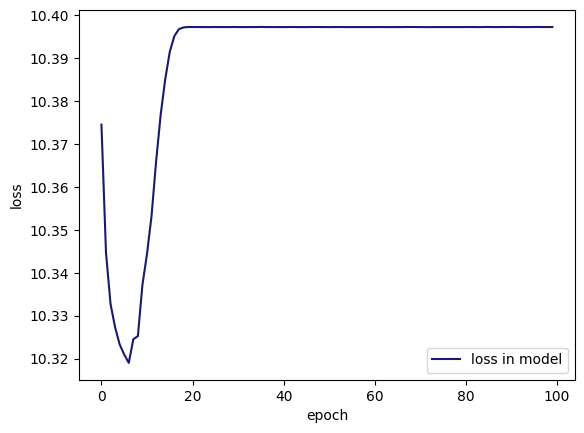

In [24]:
plt.plot(loss_list,label='loss in model',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

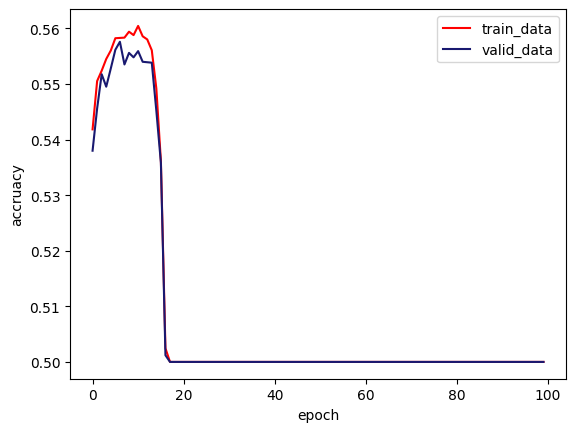

In [25]:
plt.plot(train_acc_list,label='train_data',color='red')
plt.plot(valid_acc_list,label='valid_data',color='midnightblue')
plt.xlabel('epoch')
plt.ylabel('accruacy')
plt.legend()
plt.show()